In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DATA_DIR = '/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl-big-data-bowl-2026-prediction/train'

# confirm existence
os.listdir(DATA_DIR)[:5]

['input_2023_w01.csv',
 'input_2023_w02.csv',
 'input_2023_w03.csv',
 'input_2023_w04.csv',
 'input_2023_w06.csv']

## Load the Data

In [ ]:
import pandas as pd
import glob

def load_many(pattern):
  # Build the full path pattern such as "train/input_2023_w*.csv"
  search_path = os.path.join(DATA_DIR, pattern)
  files = sorted(glob.glob(search_path))

  # Read each CSV file and collect them in a list
  dfs = [pd.read_csv(f) for f in files]

  # Combine all DataFrames into one large table
  combined = pd.concat(dfs, ignore_index=True)
  return combined

Given inp, now we add two columns vx and vy for the velocity on x-axis and velocity on y-axis respectively.

In [ ]:
import numpy as np

# Add velocity components vx, vy from speed (s) and direction (dir in degrees)
def add_vx_vy(df_group):
    g = df_group.sort_values("frame_id")
    rad = np.deg2rad(g["dir"].to_numpy())
    vx = g["s"].to_numpy() * np.cos(rad)
    vy = g["s"].to_numpy() * np.sin(rad)
    return g.assign(vx=vx, vy=vy)

### Helper Function: Load or Create

In [ ]:
def load_or_create(drive_path, local_path, create_func):
    """
    Checks if a file exists on Drive. If so, copies to local and loads.
    If not, runs create_func(), saves the result, and copies to Drive.
    """
    if os.path.exists(drive_path):
        print(f"Found existing file on Google Drive: {os.path.basename(drive_path)}. Loading...")
        # Copy from Drive to local
        !cp "{drive_path}" {local_path}

        # Load based on file type
        if local_path.endswith('.parquet'):
            df = pd.read_parquet(local_path)
        elif local_path.endswith('.csv'):
            df = pd.read_csv(local_path)
        else:
            raise ValueError(f"Unsupported file type for {local_path}")

        print("Successfully loaded. ✅")

    else:
        print(f"No file found at {drive_path}. Creating it now...")
        # Run the provided function to get the data
        df = create_func()

        print(f"Saving new file locally to: {local_path}...")

        # Save based on file type
        if local_path.endswith('.parquet'):
            df.to_parquet(local_path, index=False)
        elif local_path.endswith('.csv'):
            df.to_csv(local_path, index=False)
        else:
            raise ValueError(f"Unsupported file type for {local_path}")

        print("Copying new file to Google Drive...")
        # Copy from local to Drive
        !cp {local_path} "{drive_path}"
        print(f"New file created and saved. ✅")

    return df

### Create A Single Input File

In [ ]:
local_processed_path = "inp_processed.parquet"
drive_processed_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/inp_processed.parquet"

def create_inp_processed():
    print(f"No processed file found. Loading raw data and creating it...")
    inp = load_many('input_2023_w*.csv')

    # --- Add velocity components vx, vy ---
    print("Adding velocity components (vx, vy)...")
    inp = (inp
           .groupby(["game_id","play_id","nfl_id"], group_keys=False)
           .apply(add_vx_vy)
           .reset_index(drop=True))
    return inp

# Use the helper function
inp = load_or_create(
    drive_path=drive_processed_path,
    local_path=local_processed_path,
    create_func=create_inp_processed
)

# --- Load the 'out' data ---
print("\nLoading 'out' data...")
out = load_many('output_2023_w*.csv')
print("'out' data loaded successfully. ✅")

Found existing file on Google Drive: inp_processed.parquet. Loading...
Successfully loaded. ✅

Loading 'out' data...
'out' data loaded successfully. ✅


### Split Train/Val/Test by Game

In [ ]:
def split_by_game(df_inp, seed=1337, train=0.70, val=0.15):
    games = np.array(sorted(df_inp["game_id"].unique()))
    rng = np.random.default_rng(seed)
    rng.shuffle(games)
    n = len(games)
    n_train = int(train*n)
    n_val = int(val*n)
    g_train = set(games[:n_train])
    g_val = set(games[n_train:n_train+n_val])
    g_test = set(games[n_train+n_val:])
    return g_train, g_val, g_test

In [ ]:
# Define paths
local_path = "game_splits.csv"
drive_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/game_splits.csv"

# Game splits
def create_game_splits():
    g_train, g_val, g_test = split_by_game(inp, seed=1337)

    split_df = pd.DataFrame({
        "game_id": list(g_train) + list(g_val) + list(g_test),
        "split":   (["train"]*len(g_train) + ["val"]*len(g_val) + ["test"]*len(g_test))
    })
    return split_df

# Use the helper function
split_df = load_or_create(
    drive_path=drive_path,
    local_path=local_path,
    create_func=create_game_splits
)

# Verify the result
print("\n--- Split Info ---")
print(split_df['split'].value_counts())

Found existing file on Google Drive: game_splits.csv. Loading...
Successfully loaded. ✅

--- Split Info ---
split
train    190
test      42
val       40
Name: count, dtype: int64


In [ ]:
g_train = set(split_df[split_df['split'] == 'train']['game_id'])
g_val   = set(split_df[split_df['split'] == 'val']['game_id'])
g_test  = set(split_df[split_df['split'] == 'test']['game_id'])

print(f"Successfully loaded {len(g_train)} train, {len(g_val)} val, and {len(g_test)} test games.")

def summarize(name, game_set):
    df = inp[inp["game_id"].isin(game_set)]
    n_plays = df[["game_id","play_id"]].drop_duplicates().shape[0]
    print(f"[{name:5}] games={len(game_set):4d}  plays={n_plays:6d}  frames={len(df):9d}  unique players={df['nfl_id'].nunique():5d}")

summarize("TRAIN", g_train)
summarize("VAL",   g_val)
summarize("TEST",  g_test)

# Ensure no overlap between splits
assert g_train.isdisjoint(g_val) and g_train.isdisjoint(g_test) and g_val.isdisjoint(g_test), "Game splits overlap!"

Successfully loaded 190 train, 40 val, and 42 test games.
[TRAIN] games= 190  plays=  9794  frames=  3389897  unique players= 1318
[VAL  ] games=  40  plays=  2151  frames=   751897  unique players=  907
[TEST ] games=  42  plays=  2163  frames=   738785  unique players=  895


### Combine Input and Output

---



In [ ]:
# --- Define paths ---
local_merged_path = "data_merged.parquet"
drive_merged_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_merged.parquet"

# --- Merge input and output ---
def create_data_merged():

    # Get the single last frame from the input trajectory
    print("Filtering 'inp' to get the single last frame of each player's history...")

    inp_start_frame = inp.sort_values('frame_id').groupby(
        ['game_id', 'play_id', 'nfl_id']
    ).last().reset_index()

    # Rename output 'frame_id' to avoid conflicts
    out_renamed = out.rename(columns={'frame_id': 'frame_id_future'})

    # Perform the one-to-many merge
    print("Merging the single start frame onto the full 'out' trajectory...")
    data = inp_start_frame.merge(
        out_renamed,
        on=['game_id', 'play_id', 'nfl_id'],
        how='left',
        suffixes=('_inp', '_out')
    )

    # Add split info
    print("Merging 'split_df' information...")
    data = data.merge(split_df, on='game_id', how='left')

    # Clean up columns
    data = data.rename(columns={'frame_id': 'frame_id_start_input'})

    return data

# Use the helper function
data = load_or_create(
    drive_path=drive_merged_path,
    local_path=local_merged_path,
    create_func=create_data_merged
)

print("\n--- Head of Final Merged Data ---")
print(data.head())

Found existing file on Google Drive: data_merged.parquet. Loading...
Successfully loaded. ✅

--- Head of Final Merged Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   43290              False                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42     Jared Goff           6-4   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                        42  Jos

## ML Pipeline: Feature Engineering

### Row-wise Feature Engineering

In [ ]:
# --- Define paths for the feature-engineered DataFrame ---
local_merged_path = "data_merged.parquet"
drive_merged_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_merged.parquet"

local_features_path = "data_features.parquet"
drive_features_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_features.parquet"

def create_features():
    print(f"Loading 'data_merged.parquet' to create features...")

    !cp "{drive_merged_path}" {local_merged_path}
    df = pd.read_parquet(local_merged_path)

    # --- Ball-relative features ---
    print("Engineering ball-relative features...")
    df['dist_to_ball_land'] = np.sqrt(
        (df['ball_land_x'] - df['x_inp'])**2 +
        (df['ball_land_y'] - df['y_inp'])**2
    )
    df['angle_to_ball_land'] = np.arctan2(
        df['ball_land_y'] - df['y_inp'],
        df['ball_land_x'] - df['x_inp']
    )

    # --- Kinematic features ---
    print("Engineering kinematic features...")
    vec_x_to_ball = df['ball_land_x'] - df['x_inp']
    vec_y_to_ball = df['ball_land_y'] - df['y_inp']
    df['vel_to_ball_land'] = np.where(
        df['dist_to_ball_land'] > 0,
        (df['vx'] * vec_x_to_ball + df['vy'] * vec_y_to_ball) / df['dist_to_ball_land'],
        0
    )

    # --- Contextual (binary) features ---
    print("Engineering contextual features...")
    if 'player_role' in df.columns:
        df['is_targeted_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    if 'player_side' in df.columns:
        df['is_offense'] = (df['player_side'] == 'Offense').astype(int)
        df['is_defense'] = (df['player_side'] == 'Defense').astype(int)

    # --- Time-based ---
    print("Engineering time-based features...")
    TIME_STEP = 0.1 # 0.1 seconds per frame

    # Additional feature 1: The future frame number (1, 2, ... 21)
    # We already have this: 'frame_id_future'

    # Additional feature 2: The actual time in seconds (0.1s, 0.2s, ... 2.1s)
    df['time_to_predict'] = df['frame_id_future'] * TIME_STEP

    # Additional feature 3: Percentage of the play that has elapsed
    # (e.g., frame 1 of 21 = 0.047, frame 21 of 21 = 1.0)
    df['pct_time_elapsed'] = df['frame_id_future'] / (df['num_frames_output'] + 1e-6)

    return df

# Use the helper function
data = load_or_create(
    drive_path=drive_features_path,
    local_path=local_features_path,
    create_func=create_features
)

# Print the head and new columns to verify
print("\n--- Head of Feature-Engineered Data ---")
print(data.head())

print("\n--- New Columns Created ---")
new_cols = ['dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',
            'is_targeted_receiver', 'is_offense', 'is_defense',
            'frame_id_future', 'time_to_predict', 'pct_time_elapsed'] # <-- New features here

existing_new_cols = [col for col in new_cols if col in data.columns]
if existing_new_cols:
    print(data[existing_new_cols].describe())

Found existing file on Google Drive: data_features.parquet. Loading...
Successfully loaded. ✅

--- Head of Feature-Engineered Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   43290              False                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42     Jared Goff           6-4   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                       

### Group-wise and Relational Feature Engineering

In [ ]:
from scipy.spatial import cKDTree
from tqdm.auto import tqdm # For a progress bar!
import numpy as np

# --- Define paths ---
local_features_path = "data_features.parquet"
drive_features_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_features.parquet"

local_relational_path = "data_relational.parquet"
drive_relational_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_relational.parquet"

# --- Helper function to run on one frame at a time ---

def find_nearest_opponent(frame_df):
    """
    Calculates the distance to the nearest opponent for each player
    at a specific future frame (using x_out, y_out).
    """

    frame = frame_df.copy()

    # --- Drop NaNs ---
    # Drop any players who don't have an output coordinate (e.g., the passer)
    frame_with_coords = frame.dropna(subset=['x_out', 'y_out'])

    # Get all offense/defense players
    off_players = frame_with_coords[frame_with_coords['is_offense'] == 1]
    def_players = frame_with_coords[frame_with_coords['is_defense'] == 1]

    # Initialize the new column with NaN
    frame['dist_to_nearest_opp'] = np.nan

    # Check if we have both offense and defense players
    if off_players.empty or def_players.empty:
        return frame # Not a valid frame, return

    # --- Build the trees ---
    def_tree = cKDTree(data=def_players[['x_out', 'y_out']])
    off_tree = cKDTree(data=off_players[['x_out', 'y_out']])

    # --- Find nearest defender for each offensive player ---
    off_dists, _ = def_tree.query(off_players[['x_out', 'y_out']], k=1)

    # --- Find nearest offensive player for each defender ---
    def_dists, _ = off_tree.query(def_players[['x_out', 'y_out']], k=1)

    # --- Assign the results back to the frame ---
    frame.loc[off_players.index, 'dist_to_nearest_opp'] = off_dists
    frame.loc[def_players.index, 'dist_to_nearest_opp'] = def_dists

    return frame

# --- The create function (to pass to load_or_create) ---
def create_relational_features():
    print(f"Loading 'data_features.parquet' to create relational features...")
    !cp "{drive_features_path}" {local_features_path}
    df = pd.read_parquet(local_features_path)

    # --- Group by the future frame ID ---
    group_keys = ['game_id', 'play_id', 'frame_id_future']

    print("Calculating nearest opponent distances (for each future frame)...")
    tqdm.pandas(desc="Processing Frames")

    # --- Group on the 'df' DataFrame ---
    data_rel = (
        df.groupby(group_keys, as_index=False, group_keys=False)
             .progress_apply(find_nearest_opponent)
    )

    print("Relational features created.")
    return data_rel

# --- Use the helper function ---
data = load_or_create(
    drive_path=drive_relational_path,
    local_path=local_relational_path,
    create_func=create_relational_features
)

# --- Verify the new column ---
print("\n--- Head of Relational-Feature Data ---")
print(data.head())

print("\n--- New Column 'dist_to_nearest_opp' ---")
# Check the new column
verify_cols = ['dist_to_ball_land', 'is_offense', 'dist_to_nearest_opp']
print(data[verify_cols].describe())

Found existing file on Google Drive: data_relational.parquet. Loading...
Successfully loaded. ✅

--- Head of Relational-Feature Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   44930               True                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42  Josh Reynolds           6-3   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                     

#### Add Frame-Level & Relational Features (Separation, Closing Speed)

In [ ]:
# --- Define paths ---
local_relational_path = "data_relational.parquet"
drive_relational_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_relational.parquet"
local_final_path = "data_final_features.parquet"
drive_final_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/data_final_features.parquet"


# --- Helper function: to reduce memory ---
def downcast_dtypes(df):
    """Reduces memory usage of a DataFrame by downcasting numeric types."""
    print(f"Original memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    float_cols = df.select_dtypes(include='float').columns
    df[float_cols] = df[float_cols].astype('float32')

    int_cols = df.select_dtypes(include='integer').columns
    for col in int_cols:
        if df[col].min() >= 0 and df[col].max() <= 1:
            df[col] = df[col].astype('int8')
        elif df[col].min() >= np.iinfo('int16').min and df[col].max() <= np.iinfo('int16').max:
            df[col] = df[col].astype('int16')
        elif df[col].min() >= np.iinfo('int32').min and df[col].max() <= np.iinfo('int32').max:
            df[col] = df[col].astype('int32')

    print(f"New memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    return df


# --- Using .transform() for memory safety ---
def create_final_features_mem_safe():
    print(f"Loading 'data_relational.parquet'...")
    !cp "{drive_relational_path}" {local_relational_path}
    df = pd.read_parquet(local_relational_path)

    print("Downcasting dtypes to save RAM...")
    df = downcast_dtypes(df)

    group_keys = ['game_id', 'play_id', 'frame_id_future']

    print("Engineering frame-level features (using groupby.transform)...")

    """
    These are frame-level context features. Every player in the frame should know:
    1. What's the target's separation right now?
    2. How fast is the target moving toward the ball?
    """

    # Create the features only for the target receiver
    df['frame_separation'] = np.where(
        df['is_targeted_receiver'] == 1,
        df['dist_to_nearest_opp'],
        np.nan
    ).astype('float32')

    df['frame_target_vel_to_ball'] = np.where(
        df['is_targeted_receiver'] == 1,
        df['vel_to_ball_land'],
        np.nan
    ).astype('float32')

    # Use transform() to broadcast the target's value to all players in the frame
    print("Broadcasting target's info to all players...")
    df['frame_separation'] = df.groupby(group_keys)['frame_separation'].transform('first')
    df['frame_target_vel_to_ball'] = df.groupby(group_keys)['frame_target_vel_to_ball'].transform('first')

    # Fill NaNs for the broadcasted columns first
    print("Filling NaNs for broadcasted features...")
    df['frame_separation'] = df['frame_separation'].fillna(0)
    df['frame_target_vel_to_ball'] = df['frame_target_vel_to_ball'].fillna(0)

    # Create 'closing_speed' feature
    print("Calculating closing speed...")
    df['closing_speed_on_target'] = (df['vel_to_ball_land'] - df['frame_target_vel_to_ball']).astype('float32')

    # Handle any remaining NaNs
    df['closing_speed_on_target'] = df['closing_speed_on_target'].fillna(0)

    print("Final features created.")
    return df

# --- Use the helper function ---
data = load_or_create(
    drive_path=drive_final_path,
    local_path=local_final_path,
    create_func=create_final_features_mem_safe
)

# --- Verify the new columns ---
print("\n--- Head of Final Feature Data ---")
print(data.head())

print("\n--- New Columns ('frame_separation', 'closing_speed_on_target') ---")
verify_cols = ['frame_separation', 'frame_target_vel_to_ball', 'closing_speed_on_target']
print(data[verify_cols].describe())

print("\n--- Final Data Types (to check memory) ---")
print(data.info())

Found existing file on Google Drive: data_final_features.parquet. Loading...
Successfully loaded. ✅

--- Head of Final Feature Data ---
      game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
0  2023090700      101   44930               True                    26   
1  2023090700      101   44930               True                    26   
2  2023090700      101   44930               True                    26   
3  2023090700      101   44930               True                    26   
4  2023090700      101   44930               True                    26   

  play_direction  absolute_yardline_number    player_name player_height  \
0          right                        42  Josh Reynolds           6-3   
1          right                        42  Josh Reynolds           6-3   
2          right                        42  Josh Reynolds           6-3   
3          right                        42  Josh Reynolds           6-3   
4          right                      

# Training with LightGBM

In [ ]:
import numpy as np
import pandas as pd

model_df = data[data['x_out'].notna()].copy()

print(f"Total frames to train/val on: {len(model_df)}")

# --- Define feature columns and target columns ---
feature_cols = [
    # Original input features
    'x_inp', 'y_inp', 's', 'a', 'dir', 'o', 'vx', 'vy',
    'num_frames_output',

    # Newly added time features
    'frame_id_future',
    'time_to_predict',
    'pct_time_elapsed',

    # Static ball-relative features
    'dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',

    # Contextual features
    'is_targeted_receiver', 'is_offense', 'is_defense',

    # Dynamic & relational features
    'dist_to_nearest_opp', 'frame_separation',
    'frame_target_vel_to_ball', 'closing_speed_on_target',
]

target_cols = ['x_out', 'y_out']

# --- Create final train/val/test splits using the 'split' column ---
X_train = model_df[model_df['split'] == 'train'][feature_cols]
y_train = model_df[model_df['split'] == 'train'][target_cols]

X_val = model_df[model_df['split'] == 'val'][feature_cols]
y_val = model_df[model_df['split'] == 'val'][target_cols]

X_test = model_df[model_df['split'] == 'test'][feature_cols]
y_test = model_df[model_df['split'] == 'test'][target_cols]

print(f"Training on {len(X_train)} frames.")
print(f"Validating on {len(X_val)} frames.")
print(f"Testing on {len(X_test)} frames.")

Total frames to train/val on: 562936
Training on 388089 frames.
Validating on 87154 frames.
Testing on 87693 frames.


### Baseline Model

In [ ]:
TIME_STEP = 0.1 # 0.1 seconds per frame

t_val = X_val['time_to_predict']

# --- Constant acceleration model ---
# Compute ax and ay using a and dir
print("Calculating Constant Acceleration baseline...")
rad = np.deg2rad(X_val["dir"])
ax_val = X_val["a"] * np.cos(rad)
ay_val = X_val["a"] * np.sin(rad)

# --- Baseline predictions ---
# x_new = x_old + (vx * t) + (0.5 * ax * t^2)
x_pred_baseline = X_val['x_inp'] + (X_val['vx'] * t_val) + (0.5 * ax_val * t_val**2)
y_pred_baseline = X_val['y_inp'] + (X_val['vy'] * t_val) + (0.5 * ay_val * t_val**2)

# --- Evaluate Euclidean distance (RMSE) ---
baseline_errors = np.sqrt((x_pred_baseline - y_val['x_out'])**2 + (y_pred_baseline - y_val['y_out'])**2)
baseline_rmse = baseline_errors.mean()

print(f"Baseline (Constant Acceleration) RMSE: {baseline_rmse:.4f} yards")

Calculating Constant Acceleration baseline...
Baseline (Constant Acceleration) RMSE: 6.0026 yards


### Improved Model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import joblib # for saving/loading models

# --- Helper function for tqdm progress bar ---
def tqdm_callback(n_estimators):
    """A custom callback to display a tqdm progress bar."""
    pbar = tqdm(total=n_estimators, desc="Training Progress")

    def callback(env):
        pbar.update(1)

    return callback

# ---------------------------------------------

# --- Define hyperparameters ---
LEARNING_RATE = 0.02
N_ESTIMATORS_MAX = 8000
NUM_LEAVES = 40

model_id_string = f"LGBM_lr{str(LEARNING_RATE).replace('.', '_')}_n{N_ESTIMATORS_MAX}_nl{NUM_LEAVES}"
print(f"Model ID: {model_id_string}")

# --- Define paths ---
drive_model_x_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_x.txt"
drive_model_y_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_y.txt"

# --- Check if models are already trained and saved ---
if os.path.exists(drive_model_x_path) and os.path.exists(drive_model_y_path):
    print("Found existing models on Google Drive. Loading...")

    # Load the models
    model_x = lgb.Booster(model_file=drive_model_x_path)
    model_y = lgb.Booster(model_file=drive_model_y_path)

    print("Models loaded successfully. ✅")

else:
    print("No trained models found. Starting training...")

    # --- Predict x_out ---
    print("\nTraining x_out model...")
    model_x = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_x.fit(
        X_train, y_train['x_out'],
        eval_set=[(X_val, y_val['x_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False), # Set to False for a clean bar
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=100)
        ]
    )

    # --- Predict y_out ---
    print("\nTraining y_out model...")
    model_y = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
        # ---------------------------------------------
    )

    model_y.fit(
        X_train, y_train['y_out'],
        eval_set=[(X_val, y_val['y_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=100)
        ]
    )

    print("\nModel training complete.")

    print("Saving models to Google Drive...")

    model_dir = os.path.dirname(drive_model_x_path)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_x.booster_.save_model(drive_model_x_path)
    model_y.booster_.save_model(drive_model_y_path)
    print("Models saved. ✅")

Model ID: LGBM_lr0_02_n8000_nl40
Found existing models on Google Drive. Loading...
Models loaded successfully. ✅


In [ ]:
# --- Get predictions ---
x_pred_lgbm = model_x.predict(X_val)
y_pred_lgbm = model_y.predict(X_val)

# --- Evaluate using the Euclidean distance metric ---
lgbm_errors = np.sqrt((x_pred_lgbm - y_val['x_out'])**2 + (y_pred_lgbm - y_val['y_out'])**2)
lgbm_rmse = lgbm_errors.mean()

print(f"\n--- Model Comparison (Validation Set) ---")
print(f"Baseline (Constant Acceleration) RMSE: {baseline_rmse:.4f} yards")
print(f"LightGBM Model RMSE: {lgbm_rmse:.4f} yards")

improvement = baseline_rmse - lgbm_rmse
improvement_pct = (improvement / baseline_rmse) * 100
print(f"\nImprovement over baseline: {improvement:.4f} yards ({improvement_pct:.2f}%)")


--- Model Comparison (Validation Set) ---
Baseline (Constant Acceleration) RMSE: 6.0026 yards
LightGBM Model RMSE: 0.8828 yards

Improvement over baseline: 5.1198 yards (85.29%)

--- Model Comparison (Validation Set) ---
Baseline (Constant Acceleration) RMSE: 6.0026 yards
LightGBM Model RMSE: 0.8828 yards

Improvement over baseline: 5.1198 yards (85.29%)


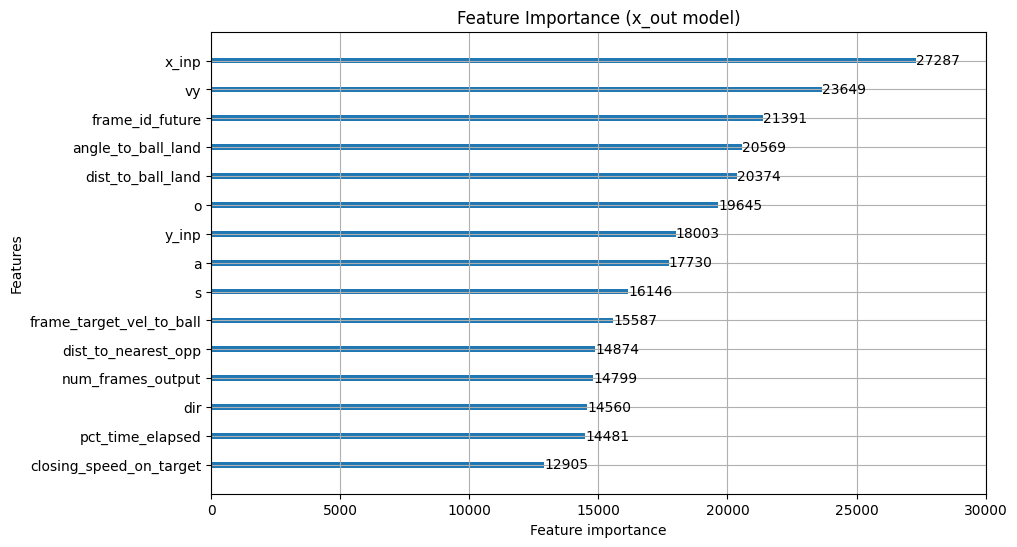

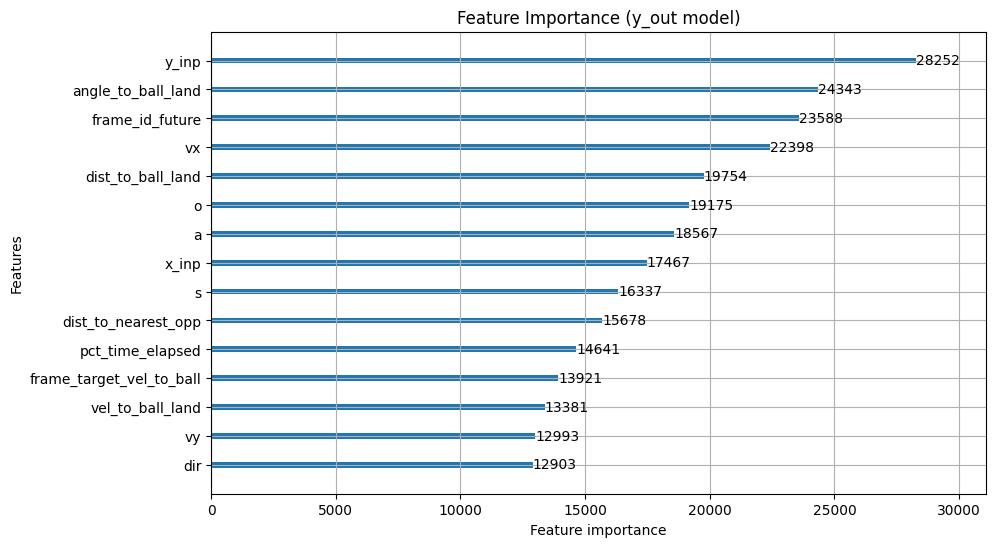

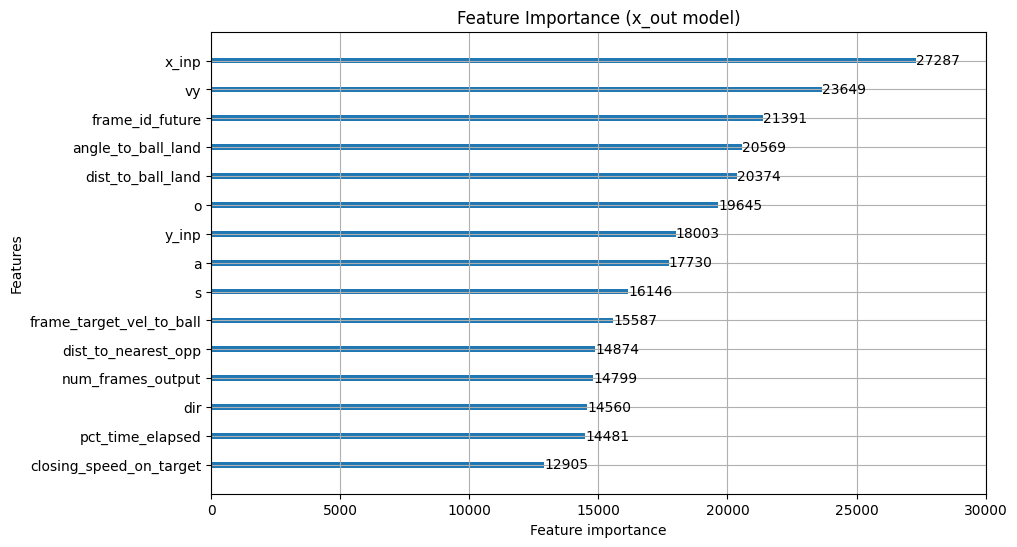

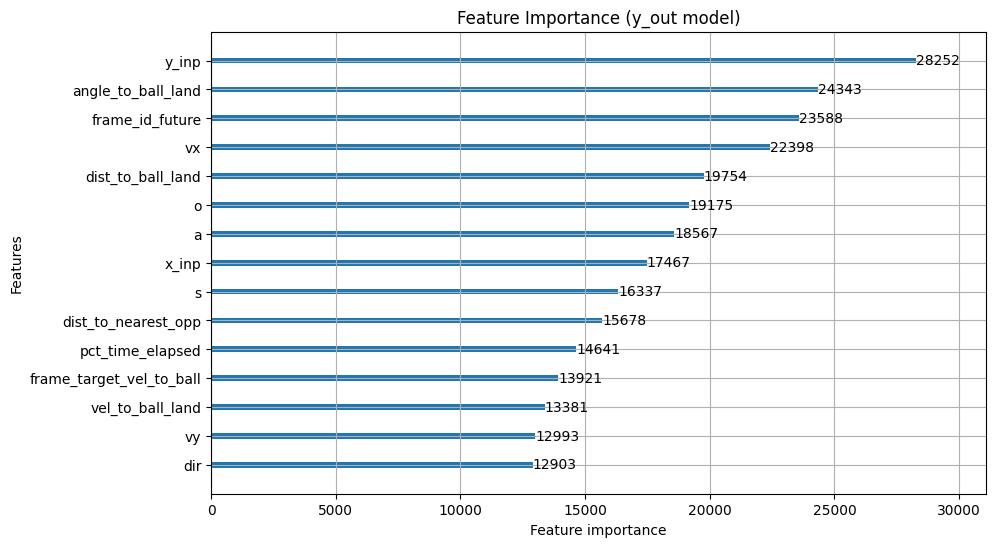

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance for the x_model
lgb.plot_importance(model_x, max_num_features=15, title="Feature Importance (x_out model)", figsize=(10, 6))
plt.show()

# Plot feature importance for the y_model
lgb.plot_importance(model_y, max_num_features=15, title="Feature Importance (y_out model)", figsize=(10, 6))
plt.show()

### Plot the Trajectory

Found existing plot on Google Drive: prediction_trajectory_comparison_LGBM_lr0_02_n8000_nl40.png. Loading...
Displaying existing plot. ✅


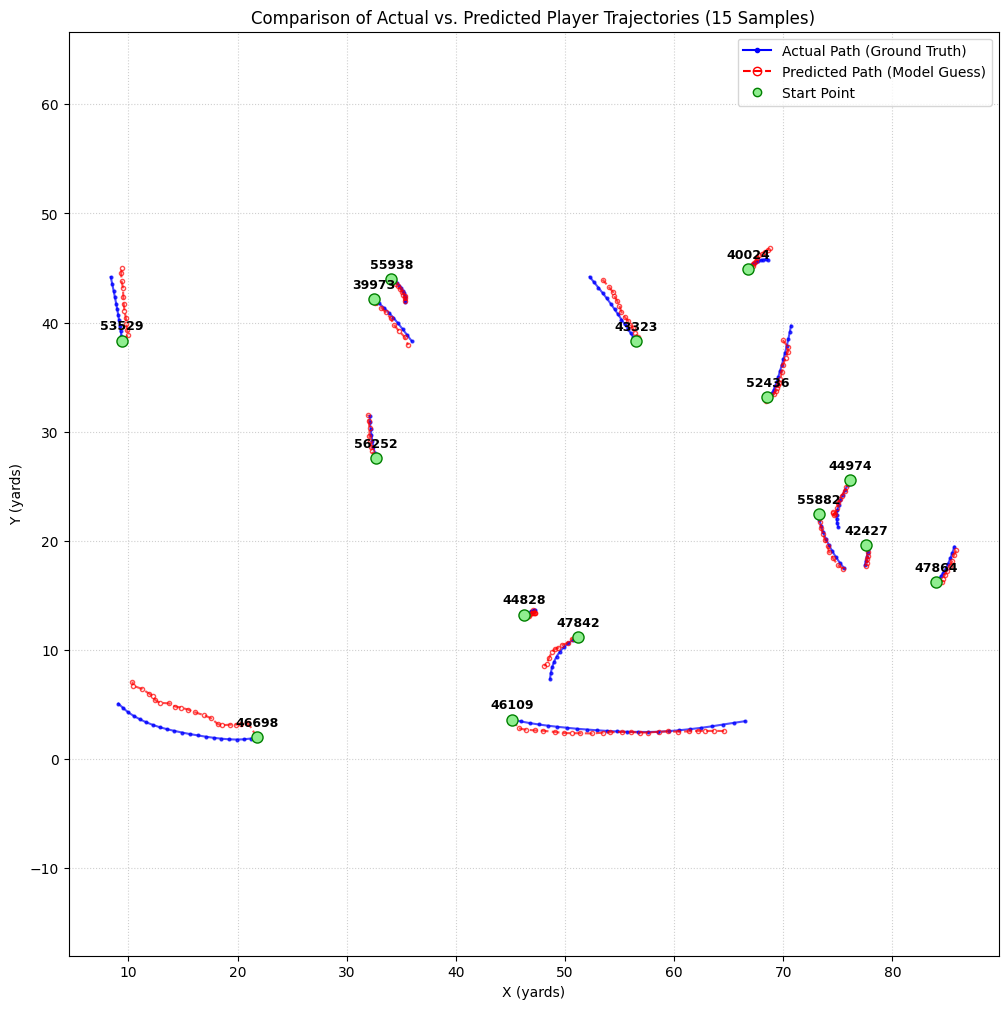

Creating plot with NFL ID labels...
Plotting 15 full trajectories...
Plot saved locally to: prediction_trajectory_comparison_LGBM_AUG.png
Copying new plot to /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/prediction_trajectory_comparison_LGBM_AUG.png...
New plot created, saved, and copied. ✅


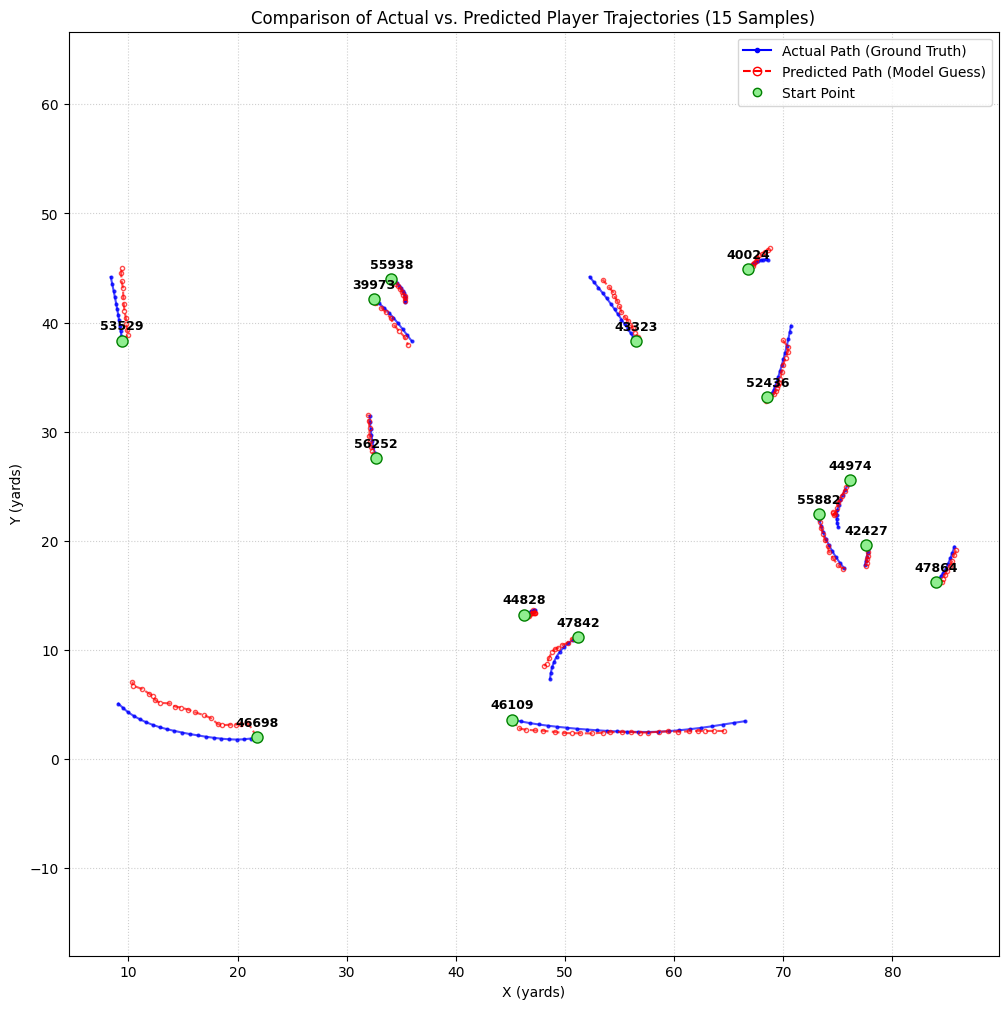

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.lines import Line2D
from IPython.display import Image, display

# --- Define paths ---
if 'model_id_string' not in locals():
    print("Warning: 'model_id_string' not found. Using default filename.")
    model_id_string = "default_model"

plot_filename = f"prediction_trajectory_comparison_{model_id_string}.png"
local_plot_path = plot_filename
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

# --- Check if plot exists ---

if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Google Drive: {os.path.basename(drive_plot_path)}. Loading...")
    !cp "{drive_plot_path}" {local_plot_path}
    print("Displaying existing plot. ✅")
    display(Image(filename=local_plot_path))

else:
    # --- If file doesn't exist, create it ---
    print(f"Creating plot with NFL ID labels...")

    # --- Combine all the data into a single DataFrame ---
    plot_df = model_df[model_df['split'] == 'val'].copy()
    plot_df['x_pred'] = x_pred_lgbm
    plot_df['y_pred'] = y_pred_lgbm

    # --- Select a random sample of players to plot ---
    N_SAMPLES = 15

    unique_keys = plot_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates()
    sample_keys = unique_keys.sample(N_SAMPLES, random_state=1337)
    sample_df = plot_df.merge(sample_keys, on=['game_id', 'play_id', 'nfl_id'])

    print(f"Plotting {N_SAMPLES} full trajectories...")

    # --- Create the plot ---
    plt.figure(figsize=(12, 12))

    # --- Draw the full trajectories for each player in the sample ---
    for (game, play, player), path_df in sample_df.groupby(['game_id', 'play_id', 'nfl_id']):

        path_df = path_df.sort_values('frame_id_future')

        # Get the start point
        start_x = path_df['x_inp'].iloc[0]
        start_y = path_df['y_inp'].iloc[0]

        # Construct the full paths
        actual_path_x = np.concatenate([[start_x], path_df['x_out']])
        actual_path_y = np.concatenate([[start_y], path_df['y_out']])
        pred_path_x = np.concatenate([[start_x], path_df['x_pred']])
        pred_path_y = np.concatenate([[start_y], path_df['y_pred']])

        # Plot the actual path
        plt.plot(actual_path_x, actual_path_y,
                 color='blue', alpha=0.7, linestyle='-', marker='.', markersize=4, label='_nolegend_')

        # Plot the predicted path
        plt.plot(pred_path_x, pred_path_y,
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none', label='_nolegend_')

        # Plot the start point
        plt.plot(start_x, start_y,
                 color='green', marker='o', markersize=8, mfc='lightgreen', label='_nolegend_')

        # --- Add the NFL ID Label ---
        # Offset the text slightly (y + 1) so it doesn't cover the green dot
        plt.text(start_x, start_y + 1, f"{int(player)}",
                 fontsize=9, color='black', fontweight='bold', ha='center')


    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='.', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label='Predicted Path (Model Guess)'),
        Line2D([0], [0], color='green', marker='o', mfc='lightgreen', linestyle='None', label='Start Point')
    ]

    # --- Plot and save the plot ---
    plt.title(f'Comparison of Actual vs. Predicted Player Trajectories ({N_SAMPLES} Samples)')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    # Save the plot to the local path
    plt.savefig(local_plot_path, bbox_inches='tight')

    plt.close()
    print(f"Plot saved locally to: {local_plot_path}")

    # --- Copy to Google Drive ---
    drive_plot_dir = os.path.dirname(drive_plot_path)
    !mkdir -p "{drive_plot_dir}"

    print(f"Copying new plot to {drive_plot_path}...")
    !cp {local_plot_path} "{drive_plot_path}"
    print(f"New plot created, saved, and copied. ✅")

    # --- Display the newly created plot ---
    display(Image(filename=local_plot_path))

# Error Analysis

### Statistics and Worst Prediction Plot

In [ ]:
# Find the worst 100 predictions in validation set, see what they all have in common.

--- ERROR ANALYSIS ---

--- Top 15 Worst Predicted Frames (Raw Data) ---
           game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
476295  2023122404     1230   54502               True                    42   
476294  2023122404     1230   54502               True                    42   
476293  2023122404     1230   54502               True                    42   
476292  2023122404     1230   54502               True                    42   
241598  2023102909     3149   53463               True                    27   
476291  2023122404     1230   54502               True                    42   
476290  2023122404     1230   54502               True                    42   
241597  2023102909     3149   53463               True                    27   
241596  2023102909     3149   53463               True                    27   
337540  2023112300     2098   56097               True                    21   
476289  2023122404     1230   54502            

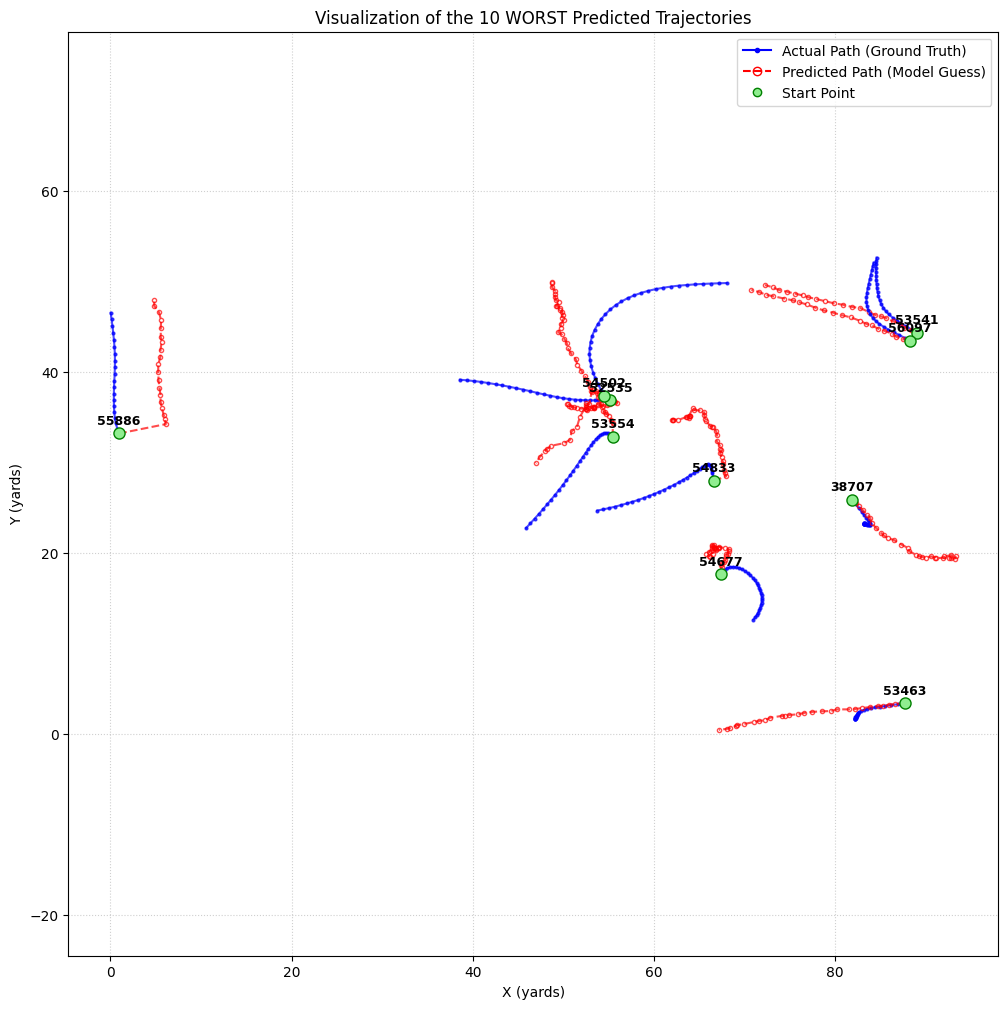

--- ERROR ANALYSIS ---

--- Top 15 Worst Predicted Frames (Raw Data) ---
           game_id  play_id  nfl_id  player_to_predict  frame_id_start_input  \
476295  2023122404     1230   54502               True                    42   
476294  2023122404     1230   54502               True                    42   
476293  2023122404     1230   54502               True                    42   
476292  2023122404     1230   54502               True                    42   
241598  2023102909     3149   53463               True                    27   
476291  2023122404     1230   54502               True                    42   
476290  2023122404     1230   54502               True                    42   
241597  2023102909     3149   53463               True                    27   
241596  2023102909     3149   53463               True                    27   
337540  2023112300     2098   56097               True                    21   
476289  2023122404     1230   54502            

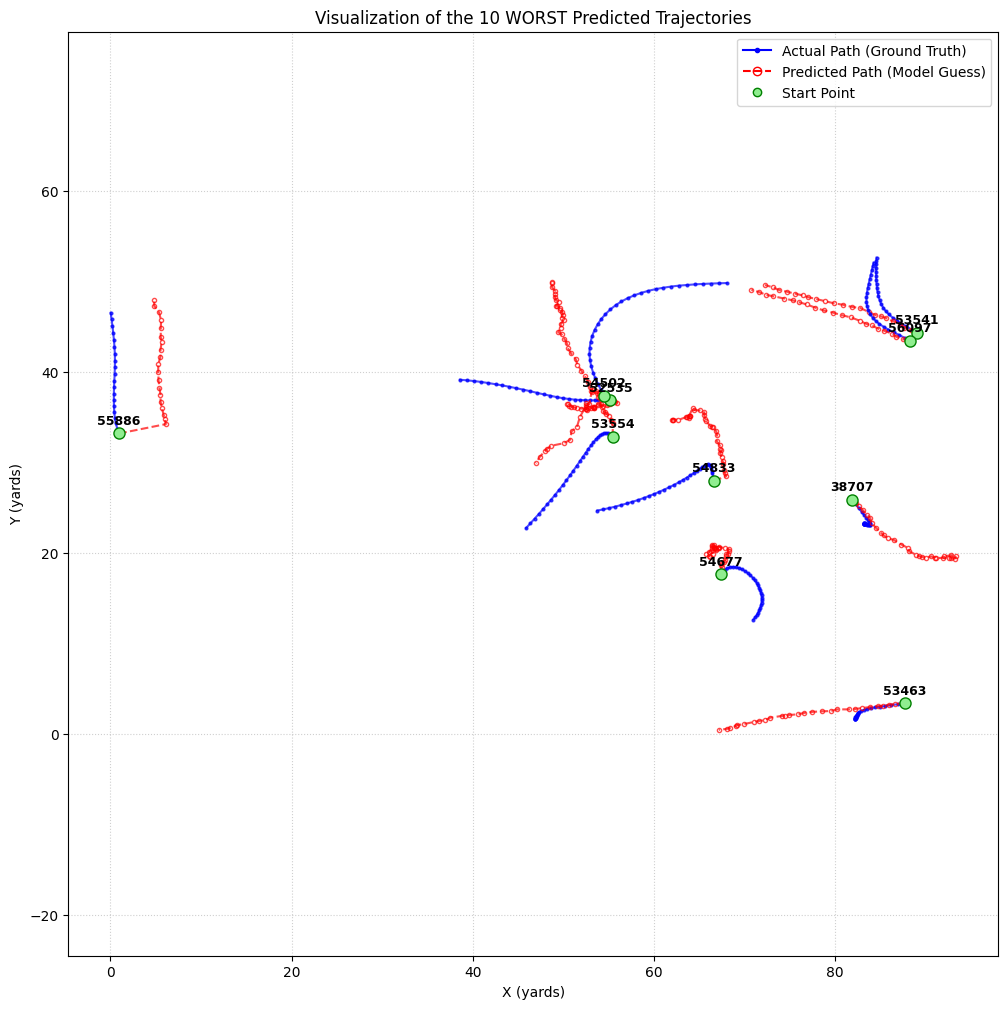

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.lines import Line2D
from IPython.display import Image, display

# --- NUMERICAL ERROR ANALYSIS ---

print("--- ERROR ANALYSIS ---")

# Get the validation set's features and true values
analysis_df = model_df[model_df['split'] == 'val'].copy()
analysis_df['x_pred'] = x_pred_lgbm
analysis_df['y_pred'] = y_pred_lgbm

# Calculate the 'error_yards' (Euclidean distance) for each frame
analysis_df['error_yards'] = np.sqrt(
    (analysis_df['x_pred'] - analysis_df['x_out'])**2 +
    (analysis_df['y_pred'] - analysis_df['y_out'])**2
)

# Sort by the error to find the worst frames
worst_frames_df = analysis_df.sort_values('error_yards', ascending=False)

print("\n--- Top 15 Worst Predicted Frames (Raw Data) ---")
print(worst_frames_df.head(15))

print("\n--- Feature Averages (Worst 100 Frames vs. All) ---")

# Compare the worst 100 frames to the validation set's average
worst_100_stats = worst_frames_df.head(100)[feature_cols].mean()
all_val_stats = analysis_df[feature_cols].mean()

# Combine them for easy comparison
stats_comparison = pd.DataFrame({
    'Worst 100 Avg': worst_100_stats,
    'All Val Avg': all_val_stats,
})
stats_comparison['Difference (Percent)'] = 100 * (stats_comparison['Worst 100 Avg'] - stats_comparison['All Val Avg']) / stats_comparison['All Val Avg']

# Display features with the biggest difference
print(stats_comparison.sort_values('Difference (Percent)', ascending=False).head(10))
print("\n" + "="*50 + "\n")


# --- VISUAL ERROR ANALYSIS ---

# --- Define paths ---
if 'model_id_string' not in locals():
    print("Warning: 'model_id_string' not found. Using default filename.")
    model_id_string = "default_model"

plot_filename = f"worst_predictions_trajectory_{model_id_string}.png"
local_plot_path = plot_filename
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

# --- Check if plot exists ---
if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Google Drive: {os.path.basename(drive_plot_path)}. Loading...")
    !cp "{drive_plot_path}" {local_plot_path}
    print("Displaying existing plot. ✅")
    display(Image(filename=local_plot_path))

else:
    # --- If file doesn't exist, create it ---
    print(f"No plot found at {drive_plot_path}. Creating it now...")

    # Group by play and get the mean error for the whole trajectory
    worst_plays = analysis_df.groupby(
        ['game_id', 'play_id', 'nfl_id']
    )['error_yards'].mean().sort_values(ascending=False)

    # Get the keys for the N worst plays
    N_SAMPLES = 10
    sample_keys = worst_plays.head(N_SAMPLES).reset_index()[['game_id', 'play_id', 'nfl_id']]

    # Get all frames only for N_SAMPLES worst player-plays
    sample_df = analysis_df.merge(sample_keys, on=['game_id', 'play_id', 'nfl_id'])

    print(f"Plotting the {N_SAMPLES} worst trajectories (by mean error)...")

    # --- Create the plot ---
    plt.figure(figsize=(12, 12))

    for (game, play, player), path_df in sample_df.groupby(['game_id', 'play_id', 'nfl_id']):

        path_df = path_df.sort_values('frame_id_future')

        # Get the single start point
        start_x = path_df['x_inp'].iloc[0]
        start_y = path_df['y_inp'].iloc[0]

        # Prepend the start point to the path arrays
        actual_path_x = np.concatenate([[start_x], path_df['x_out']])
        actual_path_y = np.concatenate([[start_y], path_df['y_out']])
        pred_path_x = np.concatenate([[start_x], path_df['x_pred']])
        pred_path_y = np.concatenate([[start_y], path_df['y_pred']])

        # Plot the ctual path
        plt.plot(actual_path_x, actual_path_y,
                 color='blue', alpha=0.7, linestyle='-', marker='.', markersize=4, label='_nolegend_')

        # Plot the predicted path
        plt.plot(pred_path_x, pred_path_y,
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none', label='_nolegend_')

        # Plot the start point
        plt.plot(start_x, start_y,
                 color='green', marker='o', markersize=8, mfc='lightgreen', label='_nolegend_')

        # --- Add the NFL ID Label ---
        # Offset the text slightly (y + 1) so it doesn't cover the green dot
        plt.text(start_x, start_y + 1, f"{int(player)}",
                 fontsize=9, color='black', fontweight='bold', ha='center')

    # --- Legend ---
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='.', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label='Predicted Path (Model Guess)'),
        Line2D([0], [0], color='green', marker='o', mfc='lightgreen', linestyle='None', label='Start Point')
    ]

    # --- Plot and save the plot ---
    plt.title(f'Visualization of the {N_SAMPLES} WORST Predicted Trajectories')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    # Save the plot to the local path
    plt.savefig(local_plot_path, bbox_inches='tight')
    plt.close()
    print(f"Plot saved locally to: {local_plot_path}")

    # --- Copy to Google Drive ---
    drive_plot_dir = os.path.dirname(drive_plot_path)
    !mkdir -p "{drive_plot_dir}"

    print(f"Copying new plot to {drive_plot_path}...")
    !cp {local_plot_path} "{drive_plot_path}"
    print(f"New plot created, saved, and copied. ✅")

    # --- Display the newly created plot ---
    display(Image(filename=local_plot_path))

### Summary

Based on the feature averages (worst 100 vs. all), the failures are driven by specific, high-speed scenarios:

*   vy (Vertical Velocity): +1048%. This is the massive outlier. The model struggles to predict players running fast in the negative y direction (down the field). It has a severe directional bias.
*   time_to_predict: +207%. The model is accurate for the first second but falls apart when asked to predict 2.4 seconds ahead. The error compounds over time.
*   Distance from Action (+116% to ball, +94% to opponent). Counter-intuitively, the model fails when players are wide open in deep space. When a player is near an opponent, their path is constrained and predictable. When they are 25 yards away in open space, they have too much freedom, and the model guesses wrong.
*   pct_time_elapsed: +64%. Errors happen at the very end of plays (88% complete). The model understands structured routes (early play) but fails when players improvise late in the down.

Overall: The visual plots confirm that the model acts as a linear extrapolator. It assumes players will keep playing the game in a straight line based on their current speed. It completely fails to predict athletic inputs, such as sharp cuts, stops, or changes in direction, especially late in the play.



# More Feature Engineering


### Fix the Linear Extrapolation Problem

In [ ]:
def add_intent_features(df):
    print("Engineering Intent Features (Angle Diff, Braking, Sidelines)...")

    # --- Angle difference ---
    # High diff implies a cut. Handles 360-degree wrap.
    diff = np.abs(df['o'] - df['dir'])
    df['angle_diff'] = np.where(diff > 180, 360 - diff, diff)

    # --- Sideline proximity ---
    # Captures behavior near sidelines (53.3 yds wide).
    df['dist_to_sideline'] = np.minimum(df['y_inp'], 53.3 - df['y_inp'])

    # --- Out of bounds flag ---
    # Flags OOB players to teach model boundaries.
    df['is_oob'] = np.where((df['y_inp'] < 0) | (df['y_inp'] > 53.3), 1, 0)

    return df

# Apply to model_df
model_df = add_intent_features(model_df)

# Check the new features
print("\n--- New Physics Features ---")
print(model_df[['angle_diff', 'dist_to_sideline', 'is_oob']].describe())

Engineering Intent Features (Angle Diff, Braking, Sidelines)...

--- New Physics Features ---
          angle_diff  dist_to_sideline    is_oob
count  562936.000000     562936.000000  562936.0
mean       74.481041         16.409151       0.0
std        47.126934          5.838866       0.0
min         0.009979          0.680000       0.0
25%        36.080017         12.110001       0.0
50%        67.739990         16.379999       0.0
75%       107.889999         21.190001       0.0
max       180.000000         26.650000       0.0
Engineering Intent Features (Angle Diff, Braking, Sidelines)...

--- New Physics Features ---
          angle_diff  dist_to_sideline    is_oob
count  562936.000000     562936.000000  562936.0
mean       74.481041         16.409151       0.0
std        47.126934          5.838866       0.0
min         0.009979          0.680000       0.0
25%        36.080017         12.110001       0.0
50%        67.739990         16.379999       0.0
75%       107.889999        

In [ ]:
# --- Add the new features to the existing list ---
feature_cols_enhanced = feature_cols + ['angle_diff', 'dist_to_sideline', 'is_oob']

print(f"Training with {len(feature_cols_enhanced)} features...")

# --- Re-split data ---
X_train_enh = model_df[model_df['split'] == 'train'][feature_cols_enhanced]
y_train_enh = model_df[model_df['split'] == 'train'][target_cols]

X_val_enh = model_df[model_df['split'] == 'val'][feature_cols_enhanced]
y_val_enh = model_df[model_df['split'] == 'val'][target_cols]

import lightgbm as lgb
import os
from tqdm.auto import tqdm

# --- Helper function for tqdm progress bar ---
def tqdm_callback(n_estimators):
    """A custom callback to display a tqdm progress bar."""
    pbar = tqdm(total=n_estimators, desc="Training Progress")

    def callback(env):
        pbar.update(1)

    return callback

# ---------------------------------------------

# --- Define hyperparameters ---
LEARNING_RATE = 0.02
N_ESTIMATORS_MAX = 8000
NUM_LEAVES = 40

# Added "_enhanced" tag to distinguish from the baseline model
model_id_string = f"LGBM_lr{str(LEARNING_RATE).replace('.', '_')}_n{N_ESTIMATORS_MAX}_nl{NUM_LEAVES}_enhanced"
print(f"Model ID: {model_id_string}")

# --- Define paths ---
drive_model_x_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_x.txt"
drive_model_y_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/{model_id_string}_model_y.txt"

# --- Check if models are already trained and saved ---
if os.path.exists(drive_model_x_path) and os.path.exists(drive_model_y_path):
    print(f"Found existing enhanced models on Google Drive. Loading...")

    # Load the models
    model_x_enhanced = lgb.Booster(model_file=drive_model_x_path)
    model_y_enhanced = lgb.Booster(model_file=drive_model_y_path)

    print("Models loaded successfully. ✅")

else:
    print("No trained enhanced models found. Starting training...")

    # --- Predict x_out ---
    print("\nTraining x_out model (Enhanced)...")
    model_x_enhanced = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_x_enhanced.fit(
        X_train_enh, y_train_enh['x_out'],
        eval_set=[(X_val_enh, y_val_enh['x_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=1000)
        ]
    )

    # --- Predict y_out ---
    print("\nTraining y_out model (Enhanced)...")
    model_y_enhanced = lgb.LGBMRegressor(
        n_estimators=N_ESTIMATORS_MAX,
        n_jobs=-1,
        random_state=1337,
        learning_rate=LEARNING_RATE,
        num_leaves=NUM_LEAVES,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model_y_enhanced.fit(
        X_train_enh, y_train_enh['y_out'],
        eval_set=[(X_val_enh, y_val_enh['y_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),
            lgb.log_evaluation(period=1000)
        ]
    )

    print("\nEnhanced model training complete.")

    print("Saving models to Google Drive...")

    model_dir = os.path.dirname(drive_model_x_path)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_x_enhanced.booster_.save_model(drive_model_x_path)
    model_y_enhanced.booster_.save_model(drive_model_y_path)
    print("Models saved. ✅")

Training with 25 features...
Model ID: LGBM_lr0_02_n8000_nl40_enhanced
Found existing enhanced models on Google Drive. Loading...
Models loaded successfully. ✅
Training with 25 features...
Model ID: LGBM_lr0_02_n8000_nl40_enhanced
Found existing enhanced models on Google Drive. Loading...
Models loaded successfully. ✅


In [ ]:
# --- Evaluate improvement ---
x_pred_enh = model_x_enhanced.predict(X_val_enh)
y_pred_enh = model_y_enhanced.predict(X_val_enh)

# Calculate RMSE
enh_errors = np.sqrt((x_pred_enh - y_val_enh['x_out'])**2 + (y_pred_enh - y_val_enh['y_out'])**2)
enh_rmse = enh_errors.mean()

print(f"\n--- Results Summary ---")
print(f"Baseline (Physics) RMSE:   {baseline_rmse:.4f}")
print(f"Previous LightGBM RMSE:    {lgbm_rmse:.4f}")
print(f"Enhanced LightGBM RMSE:    {enh_rmse:.4f}")

# Calculate gain
gain = lgbm_rmse - enh_rmse
print(f"Improvement from Feature Eng: {gain:.4f} yards per frame")


--- Results Summary ---
Baseline (Physics) RMSE:   6.0026
Previous LightGBM RMSE:    0.8828
Enhanced LightGBM RMSE:    0.8768
Improvement from Feature Eng: 0.0060 yards per frame

--- Results Summary ---
Baseline (Physics) RMSE:   6.0026
Previous LightGBM RMSE:    0.8828
Enhanced LightGBM RMSE:    0.8768
Improvement from Feature Eng: 0.0060 yards per frame


LighGBM is a snapshot model. It looks at one frame and guesses. It doesn't have memory of the past 10 frames to know a route trajectory. To fix trajectory prediction, we need to switch to an LSTM or Transformer.

# Transformer

In [ ]:
import torch
import os
import shutil

def load_or_create_torch(drive_path, local_path, create_func):
    """
    Checks if a PyTorch file exists on Drive.
    If yes -> Copies to local and loads it.
    If no  -> Runs create_func(), saves result locally and to Drive, then returns it.
    """

    drive_dir = os.path.dirname(drive_path)
    if not os.path.exists(drive_dir):
        os.makedirs(drive_dir)
        print(f"Created Drive directory: {drive_dir}")

    if os.path.exists(drive_path):
        print(f"Found existing data on Drive: {os.path.basename(drive_path)}. Loading...")
        shutil.copy(drive_path, local_path)

        data = torch.load(local_path)
        print("Successfully loaded from save. ✅")
        return data

    else:
        print(f"No file found at {drive_path}. Generating data now...")

        # --- Run the expensive function ---
        data = create_func()
        # ----------------------------------

        print(f"Saving new file locally to: {local_path}...")
        torch.save(data, local_path)

        print("Copying new file to Google Drive...")
        shutil.copy(local_path, drive_path)
        print(f"New file created and saved. ✅")

        return data

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

# --- Configuration ---
PAST_FRAMES = 10
FEATURES_TO_USE = [
    # Kinematics
    'x_inp', 'y_inp', 's', 'a', 'dir', 'o', 'vx', 'vy', 'angle_diff',
    # Context
    'dist_to_ball_land', 'angle_to_ball_land', 'vel_to_ball_land',
    # Pressure
    'dist_to_nearest_opp', 'closing_speed_on_target',
    # Roles
    'is_offense', 'is_defense', 'is_targeted_receiver'
]
TARGETS_TO_USE = ['dx', 'dy']

# --- Define paths ---
drive_tensor_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/transformer_data.pt"
local_tensor_path = "transformer_data.pt"

print(f"Preparing Data with {len(FEATURES_TO_USE)} Features...")

# --- Create sequences task ---
def create_tf_sequences_task():
    # 1. Setup DataFrame (calculate residuals & sort)
    df_tf = model_df.copy()

    # Calculate residuals (targets)
    df_tf['dx'] = df_tf['x_out'] - df_tf['x_inp']
    df_tf['dy'] = df_tf['y_out'] - df_tf['y_inp']

    # Sort by player-frame
    df_tf = df_tf.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id_start_input'])

    # 2. Scale inputs and targets
    input_scaler = StandardScaler()
    target_scaler = StandardScaler()

    df_tf[FEATURES_TO_USE] = input_scaler.fit_transform(df_tf[FEATURES_TO_USE])
    df_tf[TARGETS_TO_USE] = target_scaler.fit_transform(df_tf[TARGETS_TO_USE])

    # Save the scalers globally to use them for inference/unscaling later
    global global_target_scaler
    global_target_scaler = target_scaler

    # 3. Generate sequences
    sequences = []
    targets = []

    cols = ['game_id', 'play_id', 'nfl_id'] + FEATURES_TO_USE + TARGETS_TO_USE
    grouped = df_tf[cols].groupby(['game_id', 'play_id', 'nfl_id'])

    for _, group in tqdm(grouped, desc="Generating Sequences"):
        feats = group[FEATURES_TO_USE].values
        targs = group[TARGETS_TO_USE].values

        if len(feats) <= PAST_FRAMES: continue

        for i in range(PAST_FRAMES, len(feats)):
            sequences.append(feats[i-PAST_FRAMES : i])
            targets.append(targs[i])

    return torch.FloatTensor(np.array(sequences)), torch.FloatTensor(np.array(targets))

# --- Execute load or create function ---
X_tensor, y_tensor = load_or_create_torch(
    drive_path=drive_tensor_path,
    local_path=local_tensor_path,
    create_func=create_tf_sequences_task
)

print(f"✅ Data Ready! Input Shape: {X_tensor.shape}")

Preparing Data with 17 Features...
Found existing data on Drive: transformer_data.pt. Loading...
Successfully loaded from save. ✅
✅ Data Ready! Input Shape: torch.Size([141541, 10, 17])
Preparing Data with 17 Features...
Found existing data on Drive: transformer_data.pt. Loading...
Successfully loaded from save. ✅
✅ Data Ready! Input Shape: torch.Size([141541, 10, 17])


In [ ]:
import torch
import torch.nn as nn
import math

# --- Positional Encoding (required for Transformers) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- The Transformer encoder ---
class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=3, output_dim=2, dropout=0.2):
        super(TrajectoryTransformer, self).__init__()

        self.d_model = d_model

        # Input embedding: Map 17 features -> 128 dimensions
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer layers
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        # Output head
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)

        # Use only the last time step's output for prediction
        return self.decoder(output[:, -1, :])

In [ ]:
from sklearn.preprocessing import StandardScaler

print("Restoring scaler...")

# Ensure the target columns (dx, dy) exist in model_df
if 'dx' not in model_df.columns:
     model_df['dx'] = model_df['x_out'] - model_df['x_inp']
     model_df['dy'] = model_df['y_out'] - model_df['y_inp']

# Re-fit the scaler on the target data
# This calculates the mean and standard deviation, able to un-scale predictions later
target_scaler = StandardScaler()
target_scaler.fit(model_df[['dx', 'dy']])

# Set the global variable expected by the training loop
global_target_scaler = target_scaler

print("Scaler restored successfully! ✅ You can now run the training block.")

Restoring scaler...
Scaler restored successfully! ✅ You can now run the training block.
Restoring scaler...
Scaler restored successfully! ✅ You can now run the training block.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# ==========================================
# 1. SAFETY CHECK: Clean data first
# ==========================================
print("Checking data for NaNs...")
clean_count = 0

if torch.isnan(X_tensor).any() or torch.isinf(X_tensor).any():
    print("⚠️ Found NaNs/Infs in X_tensor. Cleaning...")
    X_tensor = torch.nan_to_num(X_tensor, nan=0.0, posinf=5.0, neginf=-5.0)
    clean_count += 1

if torch.isnan(y_tensor).any() or torch.isinf(y_tensor).any():
    print("⚠️ Found NaNs/Infs in y_tensor. Cleaning...")
    y_tensor = torch.nan_to_num(y_tensor, nan=0.0, posinf=5.0, neginf=-5.0)
    clean_count += 1

if clean_count == 0:
    print("Data was already clean. ✅")
else:
    print("Data cleaned. Re-building DataLoaders... 🔄")

# --- Hyperparameters ---
INPUT_DIM = X_tensor.shape[2] # 17
D_MODEL = 128
N_HEAD = 4
NUM_LAYERS = 3
DROPOUT = 0.2
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
NUM_EPOCHS = 30

# --- Re-create data loaders with cleaned data ---

train_size = int(0.8 * len(X_tensor))
train_dataset = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
val_dataset = TensorDataset(X_tensor[train_size:], y_tensor[train_size:])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


# ==========================================
# 2. Transformer training
# ==========================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-initialize model
model = TrajectoryTransformer(INPUT_DIM, D_MODEL, N_HEAD, NUM_LAYERS, output_dim=2, dropout=DROPOUT).to(device)

def run_transformer_training():
    print(f"Starting Transformer Training on {device}...")

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_loss = float('inf')
    best_weights = None
    patience = 8
    counter = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        valid_batches = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Skip if loss is NaN
            if torch.isnan(loss): continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            running_loss += loss.item()
            valid_batches += 1

        # Validation
        model.eval()
        val_loss = 0.0
        total_yard_error = 0.0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                # Loss
                val_loss += criterion(outputs, targets).item()

                # Real error (unscaling)
                pred_yards = global_target_scaler.inverse_transform(outputs.cpu().numpy())
                target_yards = global_target_scaler.inverse_transform(targets.cpu().numpy())

                diff = pred_yards - target_yards
                error = np.sqrt(np.sum(diff**2, axis=1))

                total_yard_error += np.sum(error)
                total_samples += len(error)

        avg_train = running_loss / valid_batches if valid_batches > 0 else 0
        avg_val = val_loss / len(val_loader)
        real_rmse = total_yard_error / total_samples if total_samples > 0 else 0

        print(f"Epoch {epoch+1} | Train: {avg_train:.5f} | Val: {avg_val:.5f} | Real Error: {real_rmse:.4f} yds")

        scheduler.step(avg_val)

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_weights = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

    return best_weights

# --- Load or Train ---
drive_tf_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/transformer_robust_v1.pt"
local_tf_path = "transformer_robust_v1.pt"

tf_weights = load_or_create_torch(
    drive_path=drive_tf_path,
    local_path=local_tf_path,
    create_func=run_transformer_training
)

model.load_state_dict(tf_weights)
print("Transformer Loaded! 🤖")

Checking data for NaNs...
⚠️ Found NaNs/Infs in X_tensor. Cleaning...
Data cleaned. Re-building DataLoaders... 🔄
Found existing data on Drive: transformer_robust_v1.pt. Loading...
Successfully loaded from save. ✅
Transformer Loaded! 🤖
Checking data for NaNs...
⚠️ Found NaNs/Infs in X_tensor. Cleaning...
Data cleaned. Re-building DataLoaders... 🔄
Found existing data on Drive: transformer_robust_v1.pt. Loading...
Successfully loaded from save. ✅
Transformer Loaded! 🤖


# CNN

### Define the Rasterizer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Field dimensions (standard NFL field)
FIELD_LENGTH = 120
FIELD_WIDTH = 54

Using device: cuda
Using device: cuda


In [ ]:
def get_play_snapshot_cnn(df, game_id, play_id, frame_id, target_nfl_id):
    """
    Generates a 4-channel image of the field.
    """
    # Initialize empty grid: [4, 54, 120]
    field_matrix = np.zeros((4, FIELD_WIDTH, FIELD_LENGTH))

    # Filter tracking data for this specific frame
    moment_data = df[
        (df['game_id'] == game_id) &
        (df['play_id'] == play_id) &
        (df['frame_id'] == frame_id)
    ]

    if moment_data.empty: return field_matrix

    # 1. Plot the ball (channel 3)
    # Ball landing data is repeated on every row, so just take the first one
    ball_x = int(moment_data.iloc[0]['ball_land_x'])
    ball_y = int(moment_data.iloc[0]['ball_land_y'])

    # Boundary check
    if 0 <= ball_x < FIELD_LENGTH and 0 <= ball_y < FIELD_WIDTH:
        field_matrix[3, ball_y, ball_x] = 1

    # 2. Plot players
    for _, player in moment_data.iterrows():
        # Convert float coords to integer pixels
        x = int(player['x'])
        y = int(player['y'])

        # Clip to field boundaries
        x = max(0, min(x, FIELD_LENGTH - 1))
        y = max(0, min(y, FIELD_WIDTH - 1))

        # Determine which channel this player goes into
        if player['nfl_id'] == target_nfl_id:
            field_matrix[2, y, x] = 1
        elif player['player_side'] == 'Offense':
            field_matrix[0, y, x] = 1
        else:
            field_matrix[1, y, x] = 1

    return field_matrix

print("Rasterizer function defined. ✅")

Rasterizer function defined. ✅
Rasterizer function defined. ✅


Visualizing Game: 2023090700, Play: 101, Frame: 1
Target Player ID: 46137


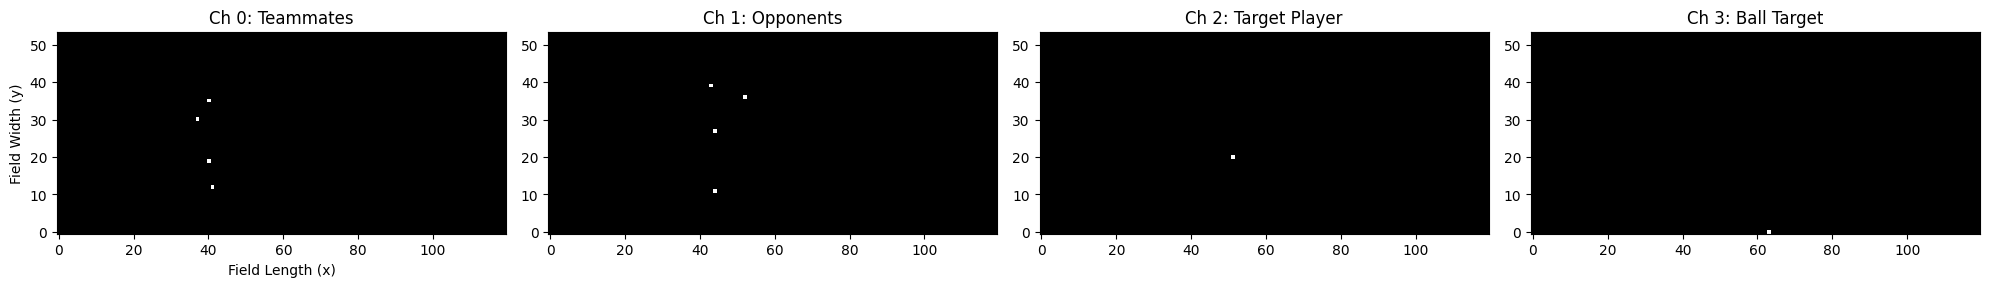

Visualizing Game: 2023090700, Play: 101, Frame: 1
Target Player ID: 46137


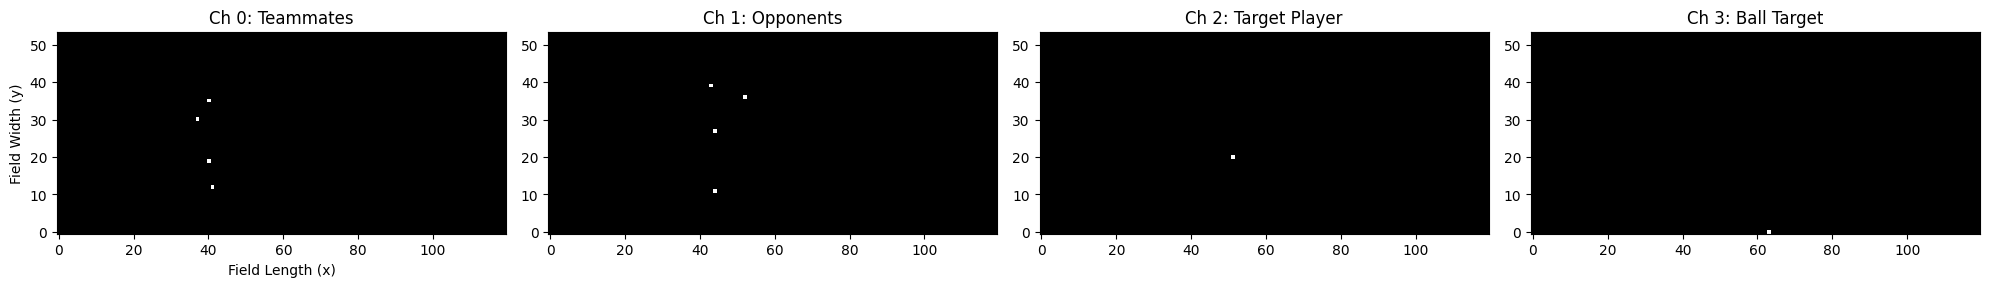

In [ ]:
# --- Pick a random TARGET player to visualize ---
target_rows = inp[inp['player_to_predict'] == True]
sample_row = target_rows.iloc[0] # Just take the first one

sample_game = sample_row['game_id']
sample_play = sample_row['play_id']
sample_frame = sample_row['frame_id']
sample_target_id = sample_row['nfl_id']

print(f"Visualizing Game: {sample_game}, Play: {sample_play}, Frame: {sample_frame}")
print(f"Target Player ID: {sample_target_id}")

# --- Generate the 4-channel image ---
field_image = get_play_snapshot_cnn(inp, sample_game, sample_play, sample_frame, sample_target_id)

# --- Visualize the 4 channels separately ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Channel 0: Teammates
axes[0].imshow(field_image[0], cmap='gray', origin='lower')
axes[0].set_title("Ch 0: Teammates")
axes[0].set_xlabel("Field Length (x)")
axes[0].set_ylabel("Field Width (y)")

# Channel 1: Opponents
axes[1].imshow(field_image[1], cmap='gray', origin='lower')
axes[1].set_title("Ch 1: Opponents")

# Channel 2: The target player
axes[2].imshow(field_image[2], cmap='gray', origin='lower')
axes[2].set_title("Ch 2: Target Player")

# Channel 3: Ball
axes[3].imshow(field_image[3], cmap='gray', origin='lower')
axes[3].set_title("Ch 3: Ball Target")

plt.tight_layout()
plt.show()

### Building the Data Pipeline

In [ ]:
class FootballCNNDataset(Dataset):
    def __init__(self, input_df, target_df):
        """
        input_df: 'inp' (Full tracking data)
        target_df: 'model_df' (Target coordinates + metadata)
        """
        self.input_df = input_df

        # Only train on rows where a valid target is present
        valid_data = target_df.dropna(subset=['x_out', 'y_out'])

        # Needs nfl_id to tell the rasterizer who the target is
        self.samples = valid_data[[
            'game_id', 'play_id', 'frame_id_start_input', 'nfl_id',
            'frame_id_future', 'x_out', 'y_out'
        ]].values

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        gid, pid, fid, nfl_id, future_frame, target_x, target_y = self.samples[idx]

        # --- Create the image ---
        img_array = get_play_snapshot_cnn(self.input_df, gid, pid, fid, nfl_id)
        img_tensor = torch.tensor(img_array, dtype=torch.float32)

        # --- Normalize the "time to predict" ---
        # Map 0-50 frames to 0.0-1.0 range
        time_val = future_frame / 50.0
        time_tensor = torch.tensor([time_val], dtype=torch.float32)

        # --- Normalize the target coordinates (outputs)
        # Map x (0-120) and y (0-54) to 0.0-1.0 range
        norm_x = target_x / 120.0
        norm_y = target_y / 54.0
        target_tensor = torch.tensor([norm_x, norm_y], dtype=torch.float32)

        return img_tensor, time_tensor, target_tensor

print("Dataset class defined. ✅")

Dataset class defined. ✅
Dataset class defined. ✅


### CNN Architecture

In [ ]:
class FootballCNN(nn.Module):
    def __init__(self):
        super(FootballCNN, self).__init__()

        # --- Vision branch (processes the image) ---
        # Input: 4 channels
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate size after 3 pooling layers:
        # Height: 54 -> 27 -> 13 -> 6
        # Width: 120 -> 60 -> 30 -> 15
        # Flat Size = 64 channels * 6 * 15 = 5760
        self.flat_size = 5760

        # --- Time branch (processes the time scalar) ---
        # Expands 1 number (time) into 64 numbers so it has "weight"
        self.time_embed = nn.Linear(1, 64)

        # --- Combined branch ---
        # Input = Image features (5760) + Time features (64)
        self.fc1 = nn.Linear(5760 + 64, 512)
        self.fc2 = nn.Linear(512, 2) # Output: x, y

    def forward(self, x, t):
        # 1. Process image
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten

        # 2. Process time
        t_vec = F.relu(self.time_embed(t))

        # 3. Combine
        combined = torch.cat((x, t_vec), dim=1)

        # 4. Predict
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

print("CNN Model architecture defined. ✅")

CNN Model architecture defined. ✅
CNN Model architecture defined. ✅


### Learning Rate Finder

Found existing Learning Rate plot! Loading... 📂
Displaying saved plot:


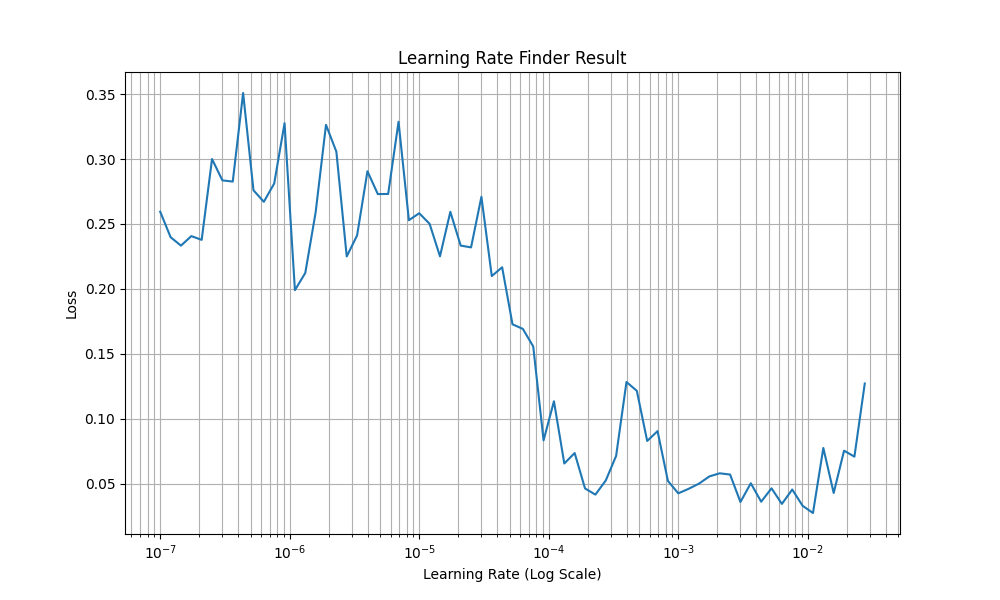

Note: View the graph above to pick your learning rate.
Found existing Learning Rate plot! Loading... 📂
Displaying saved plot:


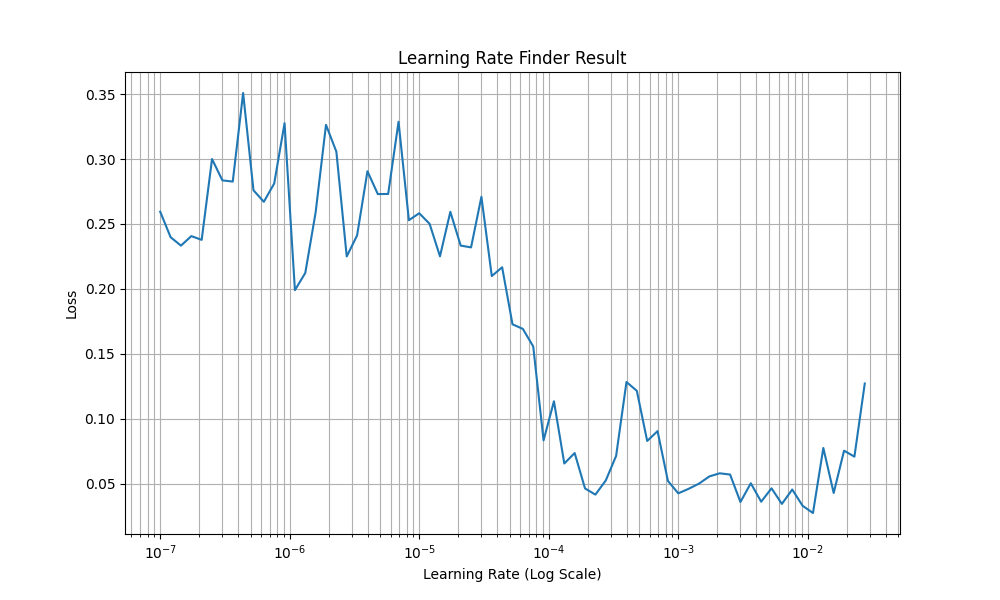

Note: View the graph above to pick your learning rate.


In [ ]:
import os
import copy
import torch
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# --- Configuration ---
BASE_PATH = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026"
FIGURES_DIR = os.path.join(BASE_PATH, "Figures")

# Define filenames
LR_PLOT_PATH = os.path.join(FIGURES_DIR, "lr_finder_plot.png")

# Ensure directories exist
os.makedirs(FIGURES_DIR, exist_ok=True)

def run_lr_finder(model, loader, criterion, device):
    """
    Runs the LR Finder experiment and saves ONLY the plot to Drive.
    """
    # --- Setup ---
    original_weights = copy.deepcopy(model.state_dict())
    model.train()

    start_lr = 1e-7
    end_lr = 10.0
    num_steps = 100
    gamma = (end_lr / start_lr) ** (1 / num_steps)

    optimizer = optim.Adam(model.parameters(), lr=start_lr)

    lrs = []
    losses = []
    current_lr = start_lr

    print("Running Learning Rate Finder Experiment... (This takes ~1-2 mins)")

    # --- Experiment Loop ---
    step = 0
    data_iter = iter(loader)

    while step < num_steps:
        try:
            images, times, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(loader)
            images, times, targets = next(data_iter)

        images, times, targets = images.to(device), times.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images, times)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(current_lr)
        losses.append(loss.item())

        current_lr *= gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        if step > 10 and loss.item() > 4 * min(losses):
            break
        step += 1

    # --- Restore model ---
    model.load_state_dict(original_weights)

    # --- Calculate best LR ---
    losses_smooth = pd.Series(losses).rolling(5, min_periods=1).mean().values
    grads = np.gradient(losses_smooth)
    best_idx = np.argmin(grads)
    suggested_lr = lrs[best_idx]

    # --- Save Plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses, label="Raw Loss", linewidth=1.5)

    plt.xscale('log')
    plt.xlabel("Learning Rate (Log Scale)")
    plt.ylabel("Loss")
    plt.title("Learning Rate Finder Result")
    plt.grid(True, which="both", ls="-")

    plt.savefig(LR_PLOT_PATH)
    print(f"✅ Plot saved to: {LR_PLOT_PATH}")
    plt.close()

    return suggested_lr


def load_or_find_lr(model, loader, criterion, device):
    """
    Smart Wrapper:
    - Checks if plot exists.
    - If yes: Shows the saved plot.
    - If no: Runs the experiment.
    """

    # Check if plot exists
    if os.path.exists(LR_PLOT_PATH):
        print("Found existing Learning Rate plot! Loading... 📂")

        # Display plot
        print("Displaying saved plot:")
        display(Image(filename=LR_PLOT_PATH))

        print("Note: View the graph above to pick your learning rate.")
        return None

    else:
        print("No existing LR experiment found. Starting fresh run... 🚀")

        # Run the worker function
        best_lr = run_lr_finder(model, loader, criterion, device)

        # Display the newly created plot
        display(Image(filename=LR_PLOT_PATH))

        return best_lr

# --- EXECUTE ---
temp_model = FootballCNN().to(device)
criterion = nn.MSELoss()
best_learning_rate = load_or_find_lr(temp_model, train_loader, criterion, device)

In [ ]:
import os
from tqdm.auto import tqdm
import torch
import numpy as np

# --- Configuration ---
MODEL_SAVE_PATH = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/cnn_full_v1.pt"
BEST_MODEL_PATH = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/cnn_best_v1.pt"

# --- Dataframe preparation (Needed for both branches) ---
train_full = model_df[model_df['split'] == 'train']
val_full = model_df[model_df['split'] == 'val']

train_ds = FootballCNNDataset(inp, train_full)
val_ds = FootballCNNDataset(inp, val_full)

if os.path.exists(BEST_MODEL_PATH):
    print(f"Model found at {BEST_MODEL_PATH}. Skipping full training!")

    # --- Load model and define necessary variables for next cells ---
    model = FootballCNN().to(device)
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    model.eval()

    # Define placeholder lists/loaders for subsequent cells
    train_losses = []
    val_losses = []
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

    print("Model loaded successfully for continued use. ✅")

else:
    os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

    print(f"Full Training Set: {len(train_full)} samples")
    print(f"Full Validation Set: {len(val_full)} samples")

    # Define loaders when training is required
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

    # --- Model & optimizer ---
    model = FootballCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    # --- TRACKING LISTS ADDED HERE ---
    train_losses = []
    val_losses = []
    # -----------------------------------

    # --- Training loop with tqdm ---
    print("Starting Full Training...")
    best_val_loss = float('inf')
    NUM_EPOCHS = 10

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0

        # --- PROGRESS BAR START ---
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

        for i, (images, times, targets) in enumerate(loop):
            images, times, targets = images.to(device), times.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, times)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Update the progress bar with current loss
            loop.set_postfix(loss=loss.item())
        # --- PROGRESS BAR END ---

        # Validation phase
        model.eval()
        val_loss = 0

        # Add a progress bar for validation
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Valid]", leave=False)

        with torch.no_grad():
            for images, times, targets in val_loop:
                images, times, targets = images.to(device), times.to(device), targets.to(device)
                outputs = model(images, times)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Calculate averages
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)

        # --- APPEND TO LISTS ---
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        # -----------------------

        scheduler.step(avg_val)

        est_yards = (avg_val ** 0.5) * 87

        # Print clean summary after the bars finish
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train:.5f}")
        print(f"  Val Loss:   {avg_val:.5f} (~{est_yards:.2f} yards)")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            print(f"  >>> New Best Model! Saving...")
            torch.save(model.state_dict(), BEST_MODEL_PATH)

    print(f"Training Finished. Saving final model to {MODEL_SAVE_PATH}...")
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("Done! ✅")

Model found at /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/cnn_best_v1.pt. Skipping full training!
Model loaded successfully for continued use. ✅
Model found at /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/cnn_best_v1.pt. Skipping full training!
Model loaded successfully for continued use. ✅


### Load the Trained CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import math

# --- Configuratiion ---
BEST_MODEL_PATH = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models/cnn_best_v1.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Model Architecture ---
class FootballCNN(nn.Module):
    def __init__(self):
        super(FootballCNN, self).__init__()

        # Vision: 4 channels -> 5760 features
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat_size = 5760 # 64 * 6 * 15

        # Time: 1 -> 64 features
        self.time_embed = nn.Linear(1, 64)

        # Combined: 5760 + 64 -> output
        self.fc1 = nn.Linear(5760 + 64, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x, t):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        t_vec = F.relu(self.time_embed(t))
        combined = torch.cat((x, t_vec), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

print("Architecture and paths defined. ✅")

Architecture and paths defined. ✅
Architecture and paths defined. ✅


In [ ]:
# --- Initialize empty model structure ---
loaded_model = FootballCNN()

# --- Load the saved weights (state_dict) ---
state_dict = torch.load(BEST_MODEL_PATH, map_location=device)

# --- Load the weights into the model structure ---
loaded_model.load_state_dict(state_dict)

# --- Move the model to the correct device (GPU) ---
loaded_model.to(device)

# --- Set the model to evaluation mode ---
loaded_model.eval()

print("Model loaded successfully! You can now use 'loaded_model' for predictions.")

Model loaded successfully! You can now use 'loaded_model' for predictions.
Model loaded successfully! You can now use 'loaded_model' for predictions.


# Transfer Learning

### Feature Extractor (Removing the Head)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- Define the feature extractor class ---
class CNNFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(CNNFeatureExtractor, self).__init__()

        # Copy the feature extraction parts from the original model
        self.conv1 = original_model.conv1
        self.conv2 = original_model.conv2
        self.conv3 = original_model.conv3
        self.pool = original_model.pool
        self.time_embed = original_model.time_embed

    def forward(self, x, t):
        # 1. Process image
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten image features

        # 2. Process time
        t_vec = F.relu(self.time_embed(t))

        # 3. Combine and output the feature vector
        combined = torch.cat((x, t_vec), dim=1)
        # This combined tensor is the 5824-dimension "Field Vision" feature set
        return combined

print("Feature Extractor class defined. ✅")

Feature Extractor class defined. ✅
Feature Extractor class defined. ✅


### Extraction and Feature Saving

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# --- Configuration ---
BASE_FEATURES_DIR = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models"

# Define the paths where the features will be saved
FINAL_MODEL_PATH = os.path.join(BASE_FEATURES_DIR, "cnn_best_v1.pt")
TRAIN_FEAT_PATH = os.path.join(BASE_FEATURES_DIR, "train_cnn_features.parquet")
VAL_FEAT_PATH = os.path.join(BASE_FEATURES_DIR, "val_cnn_features.parquet")

def extract_cnn_features(model, df_to_extract, data_tag):
    """Generates features for a given dataset (train or val)."""

    # 1. Create Data Loader for the specified subset
    extract_ds = FootballCNNDataset(inp, df_to_extract)
    extract_loader = DataLoader(extract_ds, batch_size=128, shuffle=False, num_workers=2)

    # 2. Run inference
    model.eval()
    all_features = []

    print(f"Extracting features for {data_tag} set...")

    with torch.no_grad():
        for images, times, targets in tqdm(extract_loader, desc=f"Extracting {data_tag}"):
            images, times = images.to(device), times.to(device)
            outputs = model(images, times)
            all_features.append(outputs.cpu().numpy())

    # 3. Convert results to DataFrame
    feature_matrix = np.concatenate(all_features)
    feature_df = pd.DataFrame(feature_matrix)

    # 4. Clean up columns and return
    feature_df.columns = [f'cnn_feature_{i}' for i in range(feature_matrix.shape[1])]

    # Merge the features back onto the original dataframe index
    original_idx = df_to_extract.dropna(subset=['x_out', 'y_out']).index
    feature_df.index = original_idx

    return feature_df


def load_or_extract_cnn_features(model_path, train_df, val_df):
    """
    Checks if CNN features are already saved. If yes, loads them. If no, extracts them
    using the trained model and saves them to disk.
    """

    if os.path.exists(TRAIN_FEAT_PATH) and os.path.exists(VAL_FEAT_PATH):
        print("Found existing CNN features! Loading from disk...")
        train_cnn_features = pd.read_parquet(TRAIN_FEAT_PATH)
        val_cnn_features = pd.read_parquet(VAL_FEAT_PATH)
        print("Features loaded successfully. ✅")
        return train_cnn_features, val_cnn_features

    else:
        print("No existing CNN features found. Starting extraction (approx 1 hour and 30 mins)...")

        # Load the trained CNN weights into the structure
        original_cnn = FootballCNN().to(device)
        original_cnn.load_state_dict(torch.load(model_path, map_location=device))

        # Create the new feature extractor instance
        extractor = CNNFeatureExtractor(original_cnn).to(device)
        extractor.eval()

        # Generate features for train and validation
        train_cnn_features = extract_cnn_features(extractor, train_df, "Train")
        val_cnn_features = extract_cnn_features(extractor, val_df, "Validation")

        # Save results to disk
        train_cnn_features.to_parquet(TRAIN_FEAT_PATH)
        val_cnn_features.to_parquet(VAL_FEAT_PATH)
        print(f"\nFeatures saved successfully to disk. ✅")

        return train_cnn_features, val_cnn_features

# --- EXECUTION ---
train_cnn_features, val_cnn_features = load_or_extract_cnn_features(
    FINAL_MODEL_PATH, train_full, val_full
)

print("\nFeature extraction complete. Ready to merge.")

Found existing CNN features! Loading from disk... 📂
Features loaded successfully. ✅

Feature extraction complete. Ready to merge.
Found existing CNN features! Loading from disk... 📂
Features loaded successfully. ✅

Feature extraction complete. Ready to merge.


### Merge with LightGBM

In [ ]:
import os
import pandas as pd
import numpy as np

# --- Configuration ---
BASE_DIR = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models"

# Define the paths for the final four dataframes
FINAL_X_TRAIN_PATH = os.path.join(BASE_DIR, "X_train_augmented_cnn.parquet")
FINAL_Y_TRAIN_PATH = os.path.join(BASE_DIR, "y_train_augmented_cnn.parquet")
FINAL_X_VAL_PATH = os.path.join(BASE_DIR, "X_val_augmented_cnn.parquet")
FINAL_Y_VAL_PATH = os.path.join(BASE_DIR, "y_val_augmented_cnn.parquet")


def create_augmented_data(train_cnn_features, val_cnn_features, model_df, feature_cols):
    """
    Performs feature merge, split, and saves all four dataframes
    """
    print("Starting data merge and augmentation...")

    # --- Filter main data for clean targets ---
    final_df_with_cnn = model_df.dropna(subset=['x_out', 'y_out']).copy()

    # --- Concatenate train/val features vertically since indices don't overlap ---
    master_cnn_features = pd.concat([train_cnn_features, val_cnn_features], axis=0)

    # --- Join all CNN Features onto the main dataframe by index ---
    final_df_with_cnn = final_df_with_cnn.join(master_cnn_features)

    # Fill any NaNs that resulted from the join
    final_df_with_cnn[train_cnn_features.columns] = final_df_with_cnn[train_cnn_features.columns].fillna(0)

    # --- Update feature columns ---
    # Create the final list of features (original + all 5824 CNN columns)
    feature_cols_augmented = feature_cols + list(master_cnn_features.columns)

    # --- Split and assign final dataframes (X=features, Y=targets) ---
    X_train_augmented = final_df_with_cnn[final_df_with_cnn['split'] == 'train'][feature_cols_augmented]
    X_val_augmented = final_df_with_cnn[final_df_with_cnn['split'] == 'val'][feature_cols_augmented]
    y_train = final_df_with_cnn[final_df_with_cnn['split'] == 'train'][['x_out', 'y_out']]
    y_val = final_df_with_cnn[final_df_with_cnn['split'] == 'val'][['x_out', 'y_out']]

    print("Saving final augmented feature sets to disk...")

    # --- Save the four dataframes (X_train, y_train, X_val, y_val) ---
    X_train_augmented.to_parquet(FINAL_X_TRAIN_PATH, index=False)
    y_train.to_parquet(FINAL_Y_TRAIN_PATH, index=False)
    X_val_augmented.to_parquet(FINAL_X_VAL_PATH, index=False)
    y_val.to_parquet(FINAL_Y_VAL_PATH, index=False)

    print("Data augmentation and saving complete. ✅")

    return X_train_augmented, X_val_augmented, y_train, y_val


def load_or_create_augmented_data(train_cnn_features, val_cnn_features, model_df, feature_cols):
    """
    Checks for saved files. Loads if found, runs creation if missing.
    """

    # Check for the existence of all four final files
    if (os.path.exists(FINAL_X_TRAIN_PATH) and
        os.path.exists(FINAL_Y_TRAIN_PATH) and
        os.path.exists(FINAL_X_VAL_PATH) and
        os.path.exists(FINAL_Y_VAL_PATH)):

        print("Found existing FINAL augmented datasets! Loading from disk... 📂")

        # Load all four files
        X_train_augmented = pd.read_parquet(FINAL_X_TRAIN_PATH)
        y_train = pd.read_parquet(FINAL_Y_TRAIN_PATH)
        X_val_augmented = pd.read_parquet(FINAL_X_VAL_PATH)
        y_val = pd.read_parquet(FINAL_Y_VAL_PATH)

        print("Final augmented features loaded successfully. ✅")

        return X_train_augmented, X_val_augmented, y_train, y_val

    else:
        print("Final augmented files missing. Initiating merge and split process (expensive!).")
        return create_augmented_data(train_cnn_features, val_cnn_features, model_df, feature_cols)

# --- EXECUTION ---

X_train_aug, X_val_aug, y_train, y_val = load_or_create_augmented_data(
    train_cnn_features, val_cnn_features, model_df, feature_cols
)

print(f"\nTraining set features (X): {X_train_aug.shape}")
print(f"Validation set features (X): {X_val_aug.shape}")
print(f"Total features now: {X_train_aug.shape[1]}")
print("\nReady for enhanced LightGBM training! 🚀")

Found existing FINAL augmented datasets! Loading from disk... 📂
Final augmented features loaded successfully. ✅

Training set features (X): (388089, 5846)
Validation set features (X): (87154, 5846)
Total features now: 5846

Ready for enhanced LightGBM training! 🚀
Found existing FINAL augmented datasets! Loading from disk... 📂
Final augmented features loaded successfully. ✅

Training set features (X): (388089, 5846)
Validation set features (X): (87154, 5846)
Total features now: 5846

Ready for enhanced LightGBM training! 🚀


### Train the Enhanced LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
import os
from tqdm.auto import tqdm

# --- Define paths ---
BASE_DIR = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Models"
LGBM_X_PATH = os.path.join(BASE_DIR, "LGBM_AUG_X.txt")
LGBM_Y_PATH = os.path.join(BASE_DIR, "LGBM_AUG_Y.txt")

# --- Helper function: Custom tqdm callback ---
def tqdm_callback(n_estimators):
    """A custom callback to display a tqdm progress bar for LightGBM fitting."""
    pbar = tqdm(total=n_estimators, desc="Training Progress")

    def callback(env):
        # Update the bar for each iteration
        pbar.update(1)

        # Update postfix with current RMSE from validation set
        if len(env.evaluation_result_list) > 0:
            current_rmse = env.evaluation_result_list[-1][2]
            pbar.set_postfix({'val_rmse': f'{current_rmse:.4f}'})

    return callback
# -----------------------------------------------

def calculate_rmse(x_pred, y_pred, y_true_x, y_true_y):
    """Calculates the Euclidean distance (RMSE) between predictions and actuals."""
    errors = np.sqrt((x_pred - y_true_x)**2 + (y_pred - y_true_y)**2)
    return np.mean(errors)

# --- Training worker function ---
def train_lightgbm_process(X_train, y_train, X_val, y_val, lgbm_x_path, lgbm_y_path):
    print("Starting fresh LightGBM training on augmented features... 🚀")

    # --- Hyperparameters ---
    LEARNING_RATE = 0.02
    N_ESTIMATORS_MAX = 8000
    NUM_LEAVES = 40

    # Base configuration
    params = {
        'n_estimators': N_ESTIMATORS_MAX,
        'n_jobs': -1,
        'random_state': 1337,
        'learning_rate': LEARNING_RATE,
        'num_leaves': NUM_LEAVES,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

    # 1. Train x-out model
    print("\nTraining x_out model...")
    model_x_augmented = lgb.LGBMRegressor(**params)
    model_x_augmented.fit(
        X_train, y_train['x_out'],
        eval_set=[(X_val, y_val['x_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),  # <-- TQDM CALLBACK ADDED
            lgb.log_evaluation(period=1000)
        ]
    )

    # 2. Train y-out model
    print("\nTraining y_out model...")
    model_y_augmented = lgb.LGBMRegressor(**params)
    model_y_augmented.fit(
        X_train, y_train['y_out'],
        eval_set=[(X_val, y_val['y_out'])],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(100, verbose=False),
            tqdm_callback(N_ESTIMATORS_MAX),  # <-- TQDM CALLBACK ADDED
            lgb.log_evaluation(period=1000)
        ]
    )

    # Save the models
    os.makedirs(os.path.dirname(lgbm_x_path), exist_ok=True)
    model_x_augmented.booster_.save_model(lgbm_x_path)
    model_y_augmented.booster_.save_model(lgbm_y_path)
    print("\nLightGBM models saved successfully. ✅")

    return model_x_augmented, model_y_augmented

# --- Wrapper function (The 'load or create' step) ---
def load_or_train_lgbm(X_train, y_train, X_val, y_val):

    # Check if both model files exist
    if os.path.exists(LGBM_X_PATH) and os.path.exists(LGBM_Y_PATH):
        print("Found existing Augmented LightGBM models! Loading from disk... 💾")

        # Load models
        model_x_augmented = lgb.Booster(model_file=LGBM_X_PATH)
        model_y_augmented = lgb.Booster(model_file=LGBM_Y_PATH)

        print("Models loaded successfully. ✅ (Skipping Training)")

        return model_x_augmented, model_y_augmented

    else:
        # Run training process
        return train_lightgbm_process(X_train, y_train, X_val, y_val, LGBM_X_PATH, LGBM_Y_PATH)

# --- EXECUTION ---

# Load or train the models
model_x_final, model_y_final = load_or_train_lgbm(X_train_aug, y_train, X_val_aug, y_val)

# Evaluate the final result
x_pred_final = model_x_final.predict(X_val_aug)
y_pred_final = model_y_final.predict(X_val_aug)

final_rmse = calculate_rmse(
    x_pred_final, y_pred_final,
    y_val['x_out'].values, y_val['y_out'].values
)

print("\n-------------------------------------------")
print(f"Final Augmented LightGBM RMSE: {final_rmse:.4f} yards")
print("-------------------------------------------")

Found existing Augmented LightGBM models! Loading from disk... 💾
Models loaded successfully. ✅ (Skipping Training)

-------------------------------------------
Final Augmented LightGBM RMSE: 1.0458 yards
-------------------------------------------


### Plot the Trajectory

Found existing plot on Drive: /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/prediction_trajectory_comparison_LGBM_AUG_best15.png


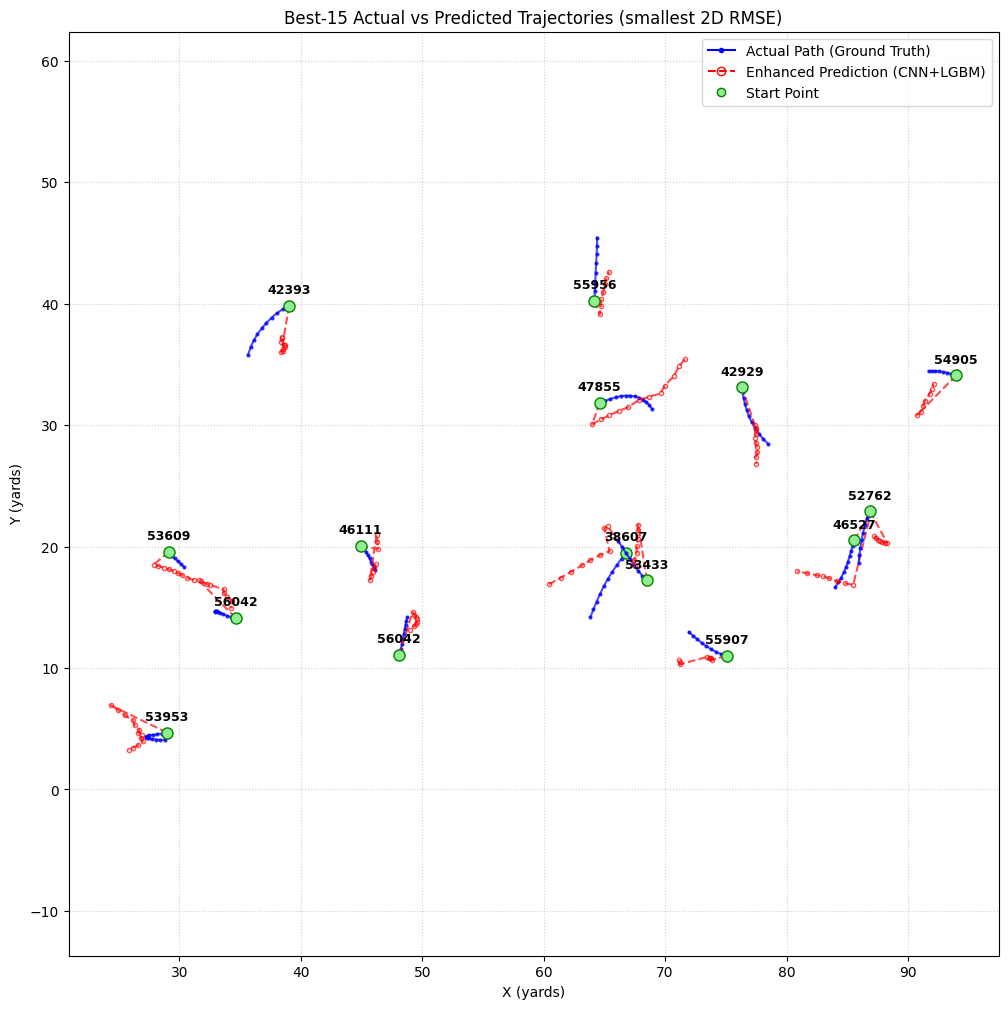

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os
from IPython.display import Image, display

# --- Define paths ---
model_id_string = "LGBM_AUG"
plot_filename = f"prediction_trajectory_comparison_{model_id_string}_best15.png"
drive_plot_path = f"/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures/{plot_filename}"

# --- If plot exists, load it from Drive ---
if os.path.exists(drive_plot_path):
    print(f"Found existing plot on Drive: {drive_plot_path}")
    display(Image(filename=drive_plot_path))

else:
    print("Creating BEST-15 trajectory plot...")

    # Build plotting dataframe
    val_index = X_val_aug.index

    plot_df = model_df.loc[val_index][[
        'game_id', 'play_id', 'nfl_id',
        'x_inp', 'y_inp',
        'x_out', 'y_out',
        'frame_id_future'
    ]].copy()

    predictions_df = pd.DataFrame(
        {'x_pred': x_pred_final, 'y_pred': y_pred_final},
        index=val_index
    )

    plot_df = plot_df.join(predictions_df)

    # Compute trajectory RMSE
    dx = plot_df['x_out'] - plot_df['x_pred']
    dy = plot_df['y_out'] - plot_df['y_pred']
    plot_df['frame_error_sq'] = dx**2 + dy**2

    group_errors = (
        plot_df
        .groupby(['game_id', 'play_id', 'nfl_id'], as_index=False)
        .apply(lambda g: np.sqrt(g['frame_error_sq'].mean()))
        .reset_index(drop=True)
    )
    group_errors.columns = ['game_id', 'play_id', 'nfl_id', 'rmse_2d']

    N_SAMPLES = 15
    N_SAMPLES = min(N_SAMPLES, len(group_errors))

    best_keys = group_errors.nsmallest(N_SAMPLES, 'rmse_2d')[
        ['game_id', 'play_id', 'nfl_id']
    ]

    sample_df = plot_df.merge(best_keys,
        on=['game_id', 'play_id', 'nfl_id'], how='inner')

    # Plot
    plt.figure(figsize=(12, 12))

    for (game, play, player), path_df in sample_df.groupby(['game_id', 'play_id', 'nfl_id']):
        path_df = path_df.sort_values('frame_id_future')

        start_x = path_df['x_inp'].iloc[0]
        start_y = path_df['y_inp'].iloc[0]

        actual_path_x = np.concatenate([[start_x], path_df['x_out'].to_numpy()])
        actual_path_y = np.concatenate([[start_y], path_df['y_out'].to_numpy()])
        pred_path_x   = np.concatenate([[start_x], path_df['x_pred'].to_numpy()])
        pred_path_y   = np.concatenate([[start_y], path_df['y_pred'].to_numpy()])

        plt.plot(actual_path_x, actual_path_y,
                 color='blue', alpha=0.7, marker='.', markersize=4, label='_nolegend_')
        plt.plot(pred_path_x, pred_path_y,
                 color='red', alpha=0.7, linestyle='--', marker='o', markersize=3, mfc='none', label='_nolegend_')

        plt.plot(start_x, start_y,
                 color='green', marker='o', markersize=8, mfc='lightgreen', label='_nolegend_')

        plt.text(start_x, start_y + 1, f"{int(player)}",
                 fontsize=9, color='black', fontweight='bold', ha='center')

    # Final formatting
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='-', marker='.', label='Actual Path (Ground Truth)'),
        Line2D([0], [0], color='red', linestyle='--', marker='o', mfc='none', label='Enhanced Prediction (CNN+LGBM)'),
        Line2D([0], [0], color='green', marker='o', mfc='lightgreen', linestyle='None', label='Start Point')
    ]

    plt.title(f'Best-{N_SAMPLES} Actual vs Predicted Trajectories (smallest 2D RMSE)')
    plt.xlabel('X (yards)')
    plt.ylabel('Y (yards)')
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.axis('equal')

    # Save to Drive
    plt.savefig(drive_plot_path, bbox_inches='tight')
    print(f"Saved BEST-15 plot to Drive:\n{drive_plot_path}")

    # Display the saved file
    display(Image(filename=drive_plot_path))


# Push Codes to GitHUb

### Set Up Git and Clone Repo

In [2]:
import os
import shutil
from google.colab import userdata

# --- Configuration ---
USERNAME = "ellydo17"
REPO_NAME = "nfl-big-data-bowl-2026-ma-797"

# --- Authentication ---
try:
    GH_TOKEN = userdata.get('GH_TOKEN')
except KeyError:
    print("Error: 'GH_TOKEN' not found in userdata.")
    raise

# Configure Git
!git config --global user.name "{USERNAME}"
!git config --global user.email "{USERNAME}@users.noreply.github.com"

# --- Safe clone logic ---
repo_url = f"https://{GH_TOKEN}@github.com/{USERNAME}/{REPO_NAME}.git"

# 1. Check if the folder already exists and delete it to avoid conflicts
if os.path.exists(REPO_NAME):
    print(f"Removing existing '{REPO_NAME}' folder to ensure a clean clone...")
    shutil.rmtree(REPO_NAME)

# 2. Clone the existing repository
print(f"Cloning {REPO_NAME} from GitHub...")
!git clone {repo_url}

print("✅ Repository cloned successfully!")

Cloning nfl-big-data-bowl-2026-ma-797 from GitHub...
Cloning into 'nfl-big-data-bowl-2026-ma-797'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 7), reused 16 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 1.17 MiB | 19.28 MiB/s, done.
Resolving deltas: 100% (7/7), done.
✅ Repository cloned successfully!


In [ ]:
# %%writefile /content/{REPO_NAME}/.gitignore
# *.parquet
# *.csv
# Models/
# *.txt
# .ipynb_checkpoints/
# __pycache__/

### Remove 'Widgets' Metadata

In [3]:
import json

notebook_path = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb"

print(f"Scanning {notebook_path} for errors...")

# --- LOAD THE NOTEBOOK DATA ---
with open(notebook_path, 'r', encoding='utf-8') as f:
    nb_data = json.load(f)

# --- REMOVE THE OFFENDING METADATA ---
if 'widgets' in nb_data['metadata']:
    print("Found incompatible 'widgets' metadata. Removing it...")
    del nb_data['metadata']['widgets']

    # --- OVERWRITE THE FILE WITH THE FIXED VERSION ---
    with open(notebook_path, 'w', encoding='utf-8') as f:
        json.dump(nb_data, f, indent=1)

    print("✅ Notebook repaired! It is now safe to push to GitHub.")

else:
    print("No 'widgets' metadata found. The notebook is already clean.")

Scanning /content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb for errors...
No 'widgets' metadata found. The notebook is already clean.


### Push Codes

In [4]:
import os

source_notebook = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/nfl_big_data_bowl_2026_stronger_model.ipynb"
source_figures = "/content/drive/MyDrive/Fall 2025/MA 797/NFL Big Data Bowl 2026/Figures"

print("Copying files from Drive to Git folder...")

!cp "{source_notebook}" /content/{REPO_NAME}/

if os.path.exists(source_figures):
    !cp -r "{source_figures}" /content/{REPO_NAME}/
else:
    print("Warning: Figures folder not found in Drive path.")

%cd /content/{REPO_NAME}
!git add .
!git commit -m "CNN model"
!git push origin main
print("\n✅ Success! Files pushed to GitHub.")

Copying files from Drive to Git folder...
/content/nfl-big-data-bowl-2026-ma-797
[main ba03ca2] CNN model
 3 files changed, 1 insertion(+), 2719 deletions(-)
 create mode 100644 Figures/lr_finder_plot.png
 create mode 100644 Figures/prediction_trajectory_comparison_LGBM_AUG_best15.png
 rewrite nfl_big_data_bowl_2026_stronger_model.ipynb (84%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 8 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 915.24 KiB | 11.30 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ellydo17/nfl-big-data-bowl-2026-ma-797.git
   e07e75b..ba03ca2  main -> main

✅ Success! Files pushed to GitHub.
